## ViT, RADNet and Hybrid Model

### Import Library

In [1]:
import os
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from transformers import AutoImageProcessor, TFAutoModelForImageClassification
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from transformers import TFViTModel, ViTFeatureExtractor, ViTModel, TFAutoModelForImageClassification
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
!pip install keras-tuner
import kerastuner as kt
!pip install lime
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import cv2  # OpenCV for image processing
import unittest
from sklearn.utils import class_weight
from collections import Counter
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from transformers import TFViTModel, ViTFeatureExtractor, TFViTForImageClassification, AutoImageProcessor, ViTFeatureExtractor, TFAutoModelForImageClassification, TFViTModel, AutoImageProcessor, ViTImageProcessor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.6 MB/s eta 0:00:00


<ipython-input-1-248b18f906e6>:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0a65afba63a3bf193a4d002a6b0082939a78f1a988588024ea3b791cd53d3fd6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


### Google Drive

In [2]:
# Mount Google Drive to access the dataset
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/Masters Project/Final Dataset/cropandalter/pickle
!ls

/content/gdrive/My Drive/Masters Project/Final Dataset/cropandalter/pickle
new_X_test.pickle  new_X_train.pickle  new_Y_test.pickle  new_Y_train.pickle  pickleo


In [4]:
%cd /content/gdrive/My Drive/Masters Project/Final Dataset/crop/pickle_r
!ls

/content/gdrive/My Drive/Masters Project/Final Dataset/crop/pickle_r
hybrid_model_large.keras	  new_Y_test_r.pickle		    uploads
hybrid_model_large_trained.keras  new_Y_train_r.pickle		    vit_model.keras
hybrid_model_small.keras	  pickleo_r			    vit_model_large.keras
hybrid_model_small_trained.keras  radnet_model_large.keras	    vit_model_large_trained.keras
my_dir				  radnet_model_large_trained.keras  vit_model_small.keras
new_X_test_r.pickle		  radnet_model_small.keras	    vit_model_small_trained.keras
new_X_train_r.pickle		  radnet_model_small_trained.keras


### Visualisation of Dataset with Augmentation (Large Dataset)

In [ ]:
labels = ['glioma_tumor_Output','no_tumor_Output','meningioma_tumor_Output','pituitary_tumor_Output']

In [ ]:
from tqdm import tqdm

new_X_train = []
new_Y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/gdrive/My Drive/Masters Project/Final Dataset/cropandalter','Training_Output',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        new_X_train.append(img)
        new_Y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/gdrive/My Drive/Masters Project/Final Dataset/cropandalter','Testing_Output',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        new_X_train.append(img)
        new_Y_train.append(i)

new_X_train = np.array(new_X_train)
new_Y_train = np.array(new_Y_train)

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color='black',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if new_Y_train[j]==i:
            ax[k].imshow(new_X_train[j])
            ax[k].set_title(new_Y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

### Visualisation of Dataset without Augmentation (Small Dataset)

In [ ]:
labels = ['glioma_tumor_Output_r','no_tumor_Output_r','meningioma_tumor_Output_r','pituitary_tumor_Output_r']

In [ ]:
from tqdm import tqdm

new_X_train_r = []
new_Y_train_r = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/gdrive/My Drive/Masters Project/Final Dataset/crop','Training_Output_r',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        new_X_train_r.append(img)
        new_Y_train_r.append(i)

for i in labels:
    folderPath = os.path.join('/content/gdrive/My Drive/Masters Project/Final Dataset/crop','Testing_Output_r',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        new_X_train_r.append(img)
        new_Y_train_r.append(i)

new_X_train_r = np.array(new_X_train_r)
new_Y_train_r = np.array(new_Y_train_r)

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color='black',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if new_Y_train_r[j]==i:
            ax[k].imshow(new_X_train_r[j])
            ax[k].set_title(new_Y_train_r[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

### Load Pickle Files

In [5]:
# Function to load pickle files
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

### Brain Tumor Classification (MRI) Dataset

#### Load Dataset

In [6]:
# Load the datasets
new_X_train = load_pickle('/content/gdrive/My Drive/Masters Project/Final Dataset/cropandalter/pickle/new_X_train.pickle')
new_X_test = load_pickle('/content/gdrive/My Drive/Masters Project/Final Dataset/cropandalter/pickle/new_X_test.pickle')
new_Y_train = load_pickle('/content/gdrive/My Drive/Masters Project/Final Dataset/cropandalter/pickle/new_Y_train.pickle')
new_Y_test = load_pickle('/content/gdrive/My Drive/Masters Project/Final Dataset/cropandalter/pickle/new_Y_test.pickle')

new_X_train_r = load_pickle('/content/gdrive/My Drive/Masters Project/Final Dataset/crop/pickle_r/new_X_train_r.pickle')
new_X_test_r = load_pickle('/content/gdrive/My Drive/Masters Project/Final Dataset/crop/pickle_r/new_X_test_r.pickle')
new_Y_train_r = load_pickle('/content/gdrive/My Drive/Masters Project/Final Dataset/crop/pickle_r/new_Y_train_r.pickle')
new_Y_test_r = load_pickle('/content/gdrive/My Drive/Masters Project/Final Dataset/crop/pickle_r/new_Y_test_r.pickle')

#### Covert Dataset to Numpy Arrays

In [7]:
# Convert datasets to numpy arrays
new_X_train = np.array(new_X_train)
new_X_test = np.array(new_X_test)
new_Y_train = np.array(new_Y_train)
new_Y_test = np.array(new_Y_test)
new_X_train_r = np.array(new_X_train_r)
new_X_test_r = np.array(new_X_test_r)
new_Y_train_r = np.array(new_Y_train_r)
new_Y_test_r = np.array(new_Y_test_r)

In [8]:
print("Data loaded successfully.")
print()
print(f"Training samples (Large Dataset - with Augmentation): {new_X_train.shape[0]}, Testing samples: {new_X_test.shape[0]}")
print()
print(f"Training samples (Small Dataset - without Augmentation): {new_X_train_r.shape[0]}, Testing samples: {new_X_test_r.shape[0]}")

Data loaded successfully.

Training samples (Large Dataset - with Augmentation): 41148, Testing samples: 10287

Training samples (Small Dataset - without Augmentation): 2611, Testing samples: 653


### Map Labels

In [9]:
# Mapping numeric labels to category names based on the original category order
label_mapping = {
    0: "no_tumor",
    1: "glioma_tumor",
    2: "meningioma_tumor",
    3: "pituitary_tumor"
}

# Map the labels for both datasets
new_Y_train = np.array([label_mapping[label] for label in new_Y_train])
new_Y_test = np.array([label_mapping[label] for label in new_Y_test])
new_Y_train_r = np.array([label_mapping[label] for label in new_Y_train_r])
new_Y_test_r = np.array([label_mapping[label] for label in new_Y_test_r])


### Class Distribution

In [10]:
# Function to visualize class distribution
def check_balance(y, dataset_name):
    counter = Counter(y)
    total = sum(counter.values())

    # Printing class distribution
    for cls, count in counter.items():
        print(f"Class {cls}: {count} samples, {count/total:.2%} of {dataset_name}")

    print()
    print()

    # Plotting the distribution
    fig, ax = plt.subplots()
    bars = ax.bar(counter.keys(), counter.values(), color='skyblue')

    # Adding labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Setting labels and title
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of samples')
    ax.set_title(f'Distribution of classes in {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### Dataset with Augmentation (Large Dataset)

Balance for new_Y_train:

Class meningioma_tumor: 10545 samples, 25.63% of Brain Tumor Train Dataset
Class pituitary_tumor: 10134 samples, 24.63% of Brain Tumor Train Dataset
Class no_tumor: 10063 samples, 24.46% of Brain Tumor Train Dataset
Class glioma_tumor: 10406 samples, 25.29% of Brain Tumor Train Dataset




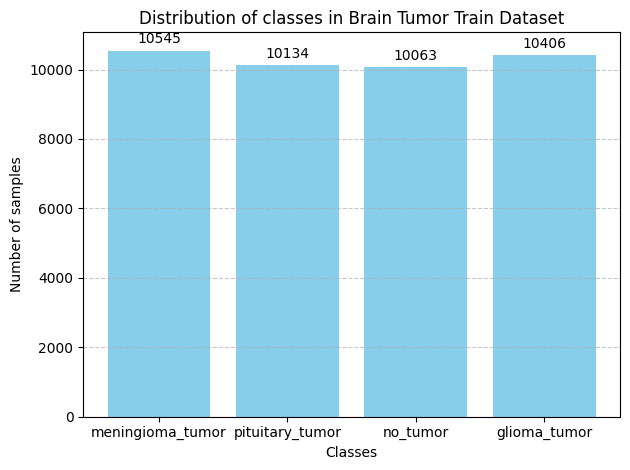

In [11]:
# Check balance for each dataset

print("Balance for new_Y_train:")
print()
check_balance(new_Y_train, "Brain Tumor Train Dataset")

Balance for new_Y_test:

Class meningioma_tumor: 2619 samples, 25.46% of Brain Tumor Test Dataset
Class no_tumor: 2532 samples, 24.61% of Brain Tumor Test Dataset
Class glioma_tumor: 2605 samples, 25.32% of Brain Tumor Test Dataset
Class pituitary_tumor: 2531 samples, 24.60% of Brain Tumor Test Dataset




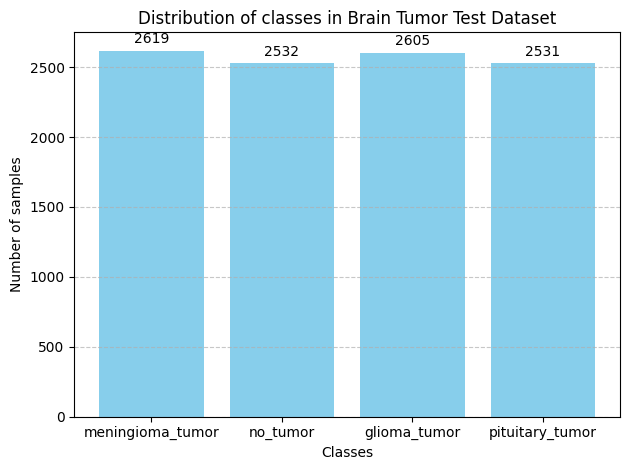

In [12]:
print("Balance for new_Y_test:")
print()
check_balance(new_Y_test, "Brain Tumor Test Dataset")

#### Dataset without Augmentation (Small Dataset)

Balance for new_Y_train_r:

Class meningioma_tumor: 765 samples, 29.30% of Brain Tumor Train Dataset (r)
Class pituitary_tumor: 722 samples, 27.65% of Brain Tumor Train Dataset (r)
Class glioma_tumor: 733 samples, 28.07% of Brain Tumor Train Dataset (r)
Class no_tumor: 391 samples, 14.98% of Brain Tumor Train Dataset (r)




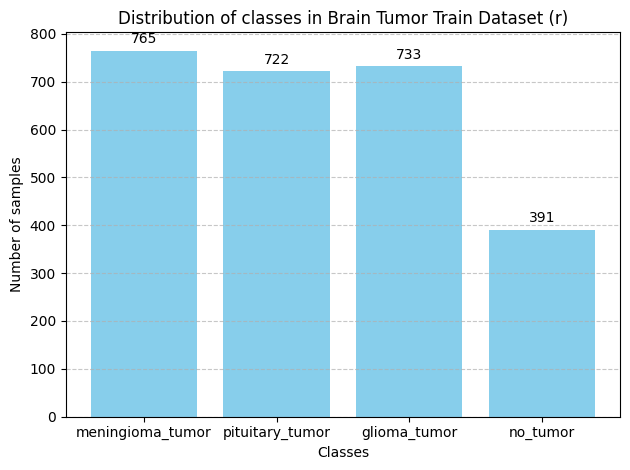

In [13]:
print("Balance for new_Y_train_r:")
print()
check_balance(new_Y_train_r, "Brain Tumor Train Dataset (r)")

Balance for new_Y_test_r:

Class no_tumor: 109 samples, 16.69% of Brain Tumor Test Dataset (r)
Class pituitary_tumor: 179 samples, 27.41% of Brain Tumor Test Dataset (r)
Class meningioma_tumor: 172 samples, 26.34% of Brain Tumor Test Dataset (r)
Class glioma_tumor: 193 samples, 29.56% of Brain Tumor Test Dataset (r)




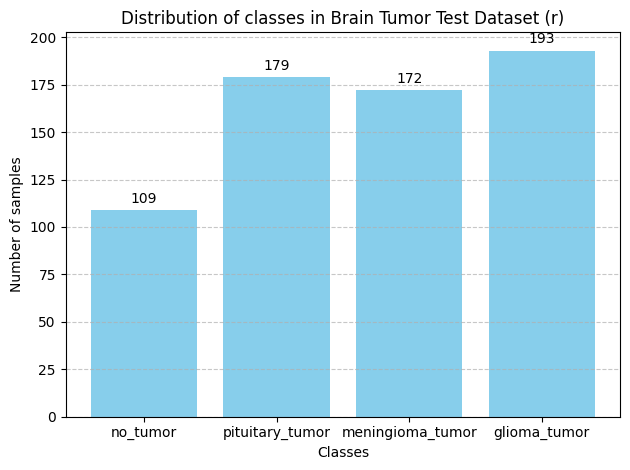

In [14]:
print("Balance for new_Y_test_r:")
print()
check_balance(new_Y_test_r, "Brain Tumor Test Dataset (r)")

#### Large Dataset

In [15]:
print("Unique labels in new_Y_train:", np.unique(new_Y_train))

Unique labels in new_Y_train: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


Before balancing:

Class meningioma_tumor: 10545 samples, 25.63% of Brain Tumor Train Dataset
Class pituitary_tumor: 10134 samples, 24.63% of Brain Tumor Train Dataset
Class no_tumor: 10063 samples, 24.46% of Brain Tumor Train Dataset
Class glioma_tumor: 10406 samples, 25.29% of Brain Tumor Train Dataset





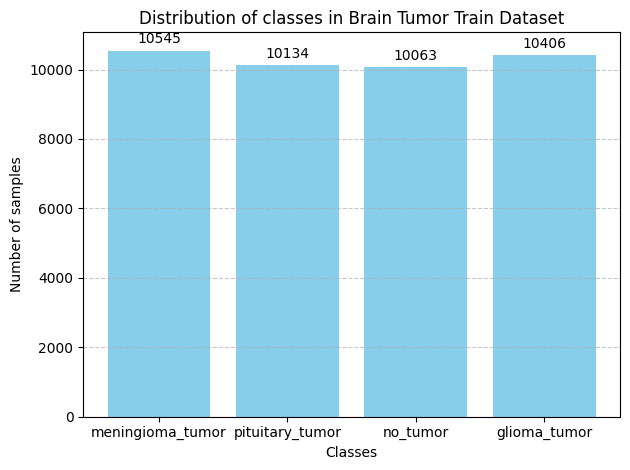




After balancing:

Class meningioma_tumor: 10545 samples, 25.00% of Brain Tumor Train Dataset Balanced
Class pituitary_tumor: 10545 samples, 25.00% of Brain Tumor Train Dataset Balanced
Class no_tumor: 10545 samples, 25.00% of Brain Tumor Train Dataset Balanced
Class glioma_tumor: 10545 samples, 25.00% of Brain Tumor Train Dataset Balanced





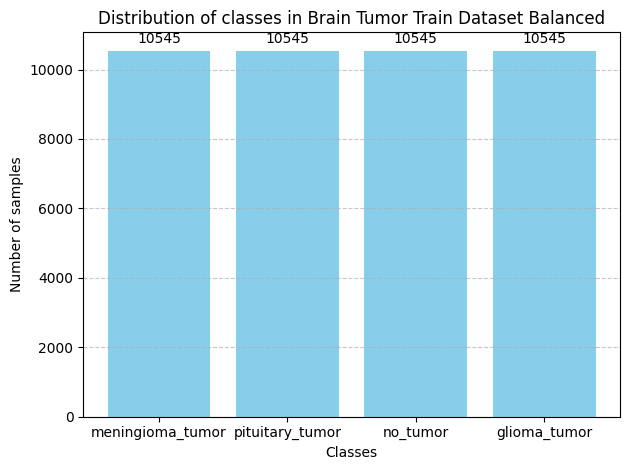

In [16]:
# Map the labels
#new_Y_train = np.array([label_mapping[label] for label in new_Y_train])
#new_Y_test = np.array([label_mapping[label] for label in new_Y_test])

# Function to visualize class distribution
def check_balance(y, dataset_name):
    counter = Counter(y)
    total = sum(counter.values())

    # Printing class distribution
    for cls, count in counter.items():
        print(f"Class {cls}: {count} samples, {count/total:.2%} of {dataset_name}")

    print()
    print()
    print()

    # Plotting the distribution
    fig, ax = plt.subplots()
    bars = ax.bar(counter.keys(), counter.values(), color='skyblue')

    # Adding labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Setting labels and title
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of samples')
    ax.set_title(f'Distribution of classes in {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Check balance before balancing
print("Before balancing:")
print()
check_balance(new_Y_train, "Brain Tumor Train Dataset")

# Flatten the image data to 2D for resampling
num_samples, height, width, channels = new_X_train.shape
new_X_train = new_X_train.reshape(num_samples, -1)

# Balancing the dataset
ros = RandomOverSampler(random_state=42)
new_X_train, new_Y_train = ros.fit_resample(new_X_train, new_Y_train)

# Reshape the resampled data back to the original image dimensions
num_resampled_samples = new_X_train.shape[0]
new_X_train = new_X_train.reshape(num_resampled_samples, height, width, channels)

print()
print()
print()

# Check balance after balancing
print("After balancing:")
print()
check_balance(new_Y_train, "Brain Tumor Train Dataset Balanced")

#### Small Dataset

In [17]:
print("Unique labels in new_Y_train_r:", np.unique(new_Y_train_r))

Unique labels in new_Y_train_r: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


Before balancing:

Class meningioma_tumor: 765 samples, 29.30% of Brain Tumor Train Dataset
Class pituitary_tumor: 722 samples, 27.65% of Brain Tumor Train Dataset
Class glioma_tumor: 733 samples, 28.07% of Brain Tumor Train Dataset
Class no_tumor: 391 samples, 14.98% of Brain Tumor Train Dataset





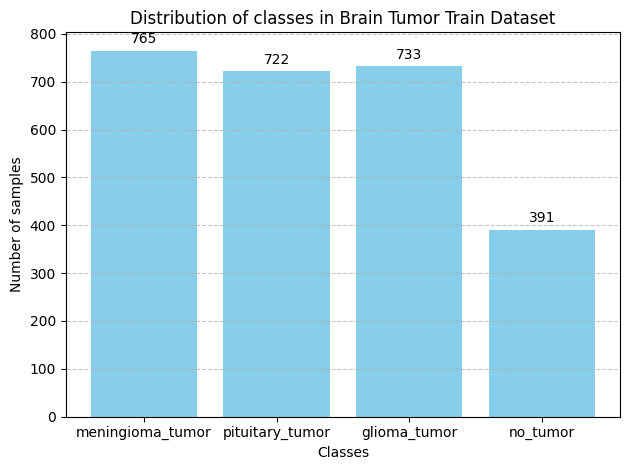




After balancing:

Class meningioma_tumor: 765 samples, 25.00% of Brain Tumor Train Dataset Balanced
Class pituitary_tumor: 765 samples, 25.00% of Brain Tumor Train Dataset Balanced
Class glioma_tumor: 765 samples, 25.00% of Brain Tumor Train Dataset Balanced
Class no_tumor: 765 samples, 25.00% of Brain Tumor Train Dataset Balanced





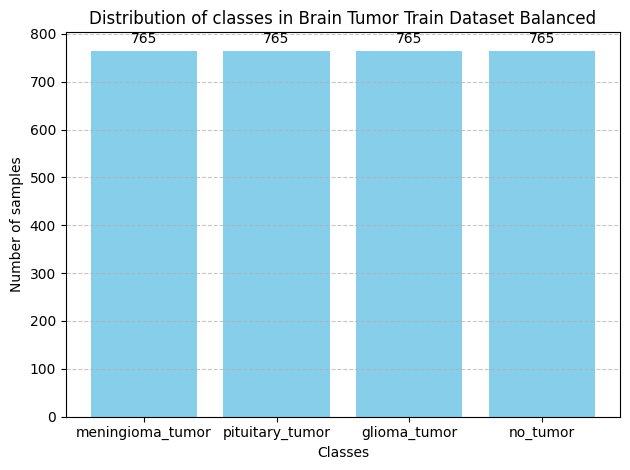

In [18]:
# Map the labels
#new_Y_train_r = np.array([label_mapping[label] for label in new_Y_train_r])
#new_Y_test_r = np.array([label_mapping[label] for label in new_Y_test_r])

# Function to visualize class distribution
def check_balance(y, dataset_name):
    counter = Counter(y)
    total = sum(counter.values())

    # Printing class distribution
    for cls, count in counter.items():
        print(f"Class {cls}: {count} samples, {count/total:.2%} of {dataset_name}")

    print()
    print()
    print()

    # Plotting the distribution
    fig, ax = plt.subplots()
    bars = ax.bar(counter.keys(), counter.values(), color='skyblue')

    # Adding labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Setting labels and title
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of samples')
    ax.set_title(f'Distribution of classes in {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Check balance before balancing
print("Before balancing:")
print()
check_balance(new_Y_train_r, "Brain Tumor Train Dataset")

# Flatten the image data to 2D for resampling
num_samples, height, width, channels = new_X_train_r.shape
new_X_train_r = new_X_train_r.reshape(num_samples, -1)

# Balancing the dataset
ros = RandomOverSampler(random_state=42)
new_X_train_r, new_Y_train_r = ros.fit_resample(new_X_train_r, new_Y_train_r)

# Reshape the resampled data back to the original image dimensions
num_resampled_samples = new_X_train_r.shape[0]
new_X_train_r = new_X_train_r.reshape(num_resampled_samples, height, width, channels)

print()
print()
print()

# Check balance after balancing
print("After balancing:")
print()
check_balance(new_Y_train_r, "Brain Tumor Train Dataset Balanced")

### Class Weights

#### Dataset with Augmentation (Large Dataset)

In [19]:
print("Shape of new_Y_train:", new_Y_train.shape)

# Compute class weights
classes = np.unique(new_Y_train)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=new_Y_train)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Shape of new_Y_train: (42180,)
Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


#### Dataset without Augmentation (Small Dataset)

In [20]:
print("Shape of new_Y_train_r:", new_Y_train_r.shape)

# Compute class weights
classes = np.unique(new_Y_train_r)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=new_Y_train_r)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Shape of new_Y_train_r: (3060,)
Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


### Encode Labels

In [21]:
from sklearn.preprocessing import LabelEncoder

# Ensure all labels are numpy arrays
new_Y_train = np.array(new_Y_train)
new_Y_test = np.array(new_Y_test)
new_Y_train_r = np.array(new_Y_train_r)
new_Y_test_r = np.array(new_Y_test_r)

# Combine all labels to fit the encoder
all_labels = np.concatenate((new_Y_train, new_Y_test, new_Y_train_r, new_Y_test_r))

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the encoder and transform the labels to integers
label_encoder.fit(all_labels)
new_Y_train_int = label_encoder.transform(new_Y_train)
new_Y_test_int = label_encoder.transform(new_Y_test)
new_Y_train_r_int = label_encoder.transform(new_Y_train_r)
new_Y_test_r_int = label_encoder.transform(new_Y_test_r)

# Number of classes
num_classes = len(label_encoder.classes_)

# One-hot encode the integer labels
new_Y_train = tf.keras.utils.to_categorical(new_Y_train_int, num_classes)
new_Y_test = tf.keras.utils.to_categorical(new_Y_test_int, num_classes)
new_Y_train_r = tf.keras.utils.to_categorical(new_Y_train_r_int, num_classes)
new_Y_test_r = tf.keras.utils.to_categorical(new_Y_test_r_int, num_classes)

print("new_Y_train")
print(new_Y_train)
print()
print("new_Y_test")
print(new_Y_test)
print()
print("new_Y_train_r")
print(new_Y_train_r)
print()
print("new_Y_test_r")
print(new_Y_test_r)

new_Y_train
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]

new_Y_test
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

new_Y_train_r
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]

new_Y_test_r
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


### Hugging Face

In [ ]:
# Token
HF_TOKEN = "your_token_here"

# Set the token as an environment variable
import os
os.environ['HF_TOKEN'] = HF_TOKEN

In [23]:
%%time
# Load the pre-trained model and processor
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model_vit = TFAutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


CPU times: user 1.56 s, sys: 684 ms, total: 2.24 s
Wall time: 6.61 s


In [24]:
import os

# Ensure the token is set correctly
hf_token = os.getenv('HF_TOKEN')

if hf_token is None:
    raise ValueError("The HF_TOKEN does not exist in your environment variables")

# Save token for Hugging Face
from huggingface_hub import HfFolder
HfFolder.save_token(hf_token)

### ViT Model

#### Cutom Layers for ViT Model

In [25]:
### ViT Model

#### Custom Layers

# Custom Layers for ViT Model
class PatchEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, patch_size, embed_dim, **kwargs):
        super(PatchEmbeddingLayer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(self.patch_size, self.patch_size, input_shape[-1], self.embed_dim),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel"
        )

    def call(self, inputs):
        return tf.nn.conv2d(inputs, self.kernel, strides=[1, self.patch_size, self.patch_size, 1], padding='VALID')

class PreprocessLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        def preprocess_image(image):
            image = tf.image.resize(image, (224, 224))
            image = image / 255.0
            if image.shape[-1] == 1:
                image = tf.image.grayscale_to_rgb(image)
            return image

        return tf.map_fn(preprocess_image, inputs, fn_output_signature=tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32))

class TransposeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.transpose(inputs, [0, 3, 1, 2])

class ViTFeatureExtractor(layers.Layer):
    def __init__(self, vit_model, processor, **kwargs):
        super(ViTFeatureExtractor, self).__init__(**kwargs)
        self.vit_model = vit_model
        self.processor = processor

    def call(self, inputs):
        preprocessed_inputs = PreprocessLayer()(inputs)
        preprocessed_inputs = TransposeLayer()(preprocessed_inputs)
        vit_output = self.vit_model.vit(preprocessed_inputs).last_hidden_state
        return vit_output

    def get_config(self):
        config = super(ViTFeatureExtractor, self).get_config()
        config.update({
            "vit_model": self.vit_model.name_or_path,
            "processor": self.processor.__class__.__name__,
        })
        return config

    @classmethod
    def from_config(cls, config):
        vit_model = TFViTModel.from_pretrained(config.pop('vit_model'))
        processor_class = globals()[config.pop('processor')]
        processor = processor_class.from_pretrained(vit_model.name_or_path)
        return cls(vit_model, processor, **config)


In [26]:
# Register Custom Layers
custom_layers = {
    "PatchEmbeddingLayer": PatchEmbeddingLayer,
    "PreprocessLayer": PreprocessLayer,
    "TransposeLayer": TransposeLayer,
    "ViTFeatureExtractor": ViTFeatureExtractor,
}

for layer_name, layer_class in custom_layers.items():
    tf.keras.utils.get_custom_objects()[layer_name] = layer_class

#### Defining ViT Model

In [27]:
# Hyperparameter tuning for ViT Model
def build_vit_model_hp(hp):
    inputs = layers.Input(shape=(224, 224, 3))
    vit_output = ViTFeatureExtractor(model_vit, processor)(inputs)
    vit_output = layers.GlobalAveragePooling1D()(vit_output)
    x = layers.Dense(hp.Int('dense_1_units', min_value=256, max_value=512, step=128), activation='relu')(vit_output)
    x = layers.Dropout(hp.Float('dropout_1', 0.3, 0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('dense_2_units', min_value=128, max_value=256, step=64), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_2', 0.3, 0.5, step=0.1))(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    vit_model = models.Model(inputs, outputs, name="ViT_Model")

    vit_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('lr', 1e-5, 1e-3, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    return vit_model


In [28]:
# Setup Keras Tuner for hyperparameter tuning
tuner_vit = kt.Hyperband(
    build_vit_model_hp,
    objective='val_accuracy',
    max_epochs=10,
    factor=2,
    directory='my_dir',
    project_name='vit_tuning'
)

Reloading Tuner from my_dir/vit_tuning/tuner0.json


### Data Augmentation

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation process
datagen = ImageDataGenerator(
    rotation_range=20,            # Rotate images by a maximum of 20 degrees
    width_shift_range=0.2,        # Shift images horizontally by 20% of the width
    height_shift_range=0.2,       # Shift images vertically by 20% of the height
    shear_range=0.2,              # Apply a shear transformation of 20%
    zoom_range=0.2,               # Zoom in or out by 20%
    horizontal_flip=True,         # Flip images horizontally
    fill_mode='nearest'           # Fill in any gaps created by the transformations with the nearest pixel value
)

# Augmented data generator
train_generator = datagen.flow(new_X_train, new_Y_train, batch_size=32)

### RADNet Model

In [30]:
# Hyperparameter tuning for RADNet Model
def build_radnet_model_hp(hp):
    input_shape = (224, 224, 3)
    num_classes = 4

    inputs = layers.Input(shape=input_shape)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model(inputs, training=False)

    # Additional Convolutional Layers with higher parameters
    x = layers.Conv2D(
        hp.Int('conv_1_filters', min_value=384, max_value=512, step=64, default=512),
        (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(hp.Float('l2', 1e-4, 1e-3, sampling='LOG', default=1e-3))
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(
        hp.Int('conv_2_filters', min_value=384, max_value=512, step=64, default=512),
        (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(hp.Float('l2', 1e-4, 1e-3, sampling='LOG', default=1e-3))
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(
        hp.Int('conv_3_filters', min_value=384, max_value=512, step=64, default=512),
        (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(hp.Float('l2', 1e-4, 1e-3, sampling='LOG', default=1e-3))
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(hp.Float('dropout_1', 0.4, 0.6, step=0.1, default=0.5))(x)
    x = layers.Dense(
        hp.Int('dense_1_units', min_value=384, max_value=512, step=64, default=512),
        activation='relu', kernel_regularizer=regularizers.l2(hp.Float('l2', 1e-4, 1e-3, sampling='LOG', default=1e-3))
    )(x)
    x = layers.Dropout(hp.Float('dropout_2', 0.4, 0.6, step=0.1, default=0.5))(x)
    x = layers.Dense(
        hp.Int('dense_2_units', min_value=384, max_value=512, step=64, default=512),
        activation='relu', kernel_regularizer=regularizers.l2(hp.Float('l2', 1e-4, 1e-3, sampling='LOG', default=1e-3))
    )(x)
    x = layers.Dropout(hp.Float('dropout_3', 0.4, 0.6, step=0.1, default=0.5))(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    radnet_model = models.Model(inputs, outputs, name="RADNet_Model")

    radnet_model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Float('lr', 1e-4, 1e-3, sampling='LOG', default=1e-4)),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    return radnet_model

#### Hyperparameter Tuning: RADNet Model

In [31]:
# Setup Keras Tuner for hyperparameter tuning
tuner_radnet = kt.Hyperband(
    build_radnet_model_hp,
    objective='val_accuracy',
    max_epochs=10,
    factor=2,
    directory='my_dir',
    project_name='radnet_tuning'
)

Reloading Tuner from my_dir/radnet_tuning/tuner0.json


### Hyperparameter Tuning

In [32]:
# Hyperparameter tuning for RADNet Model
tuner_radnet.search(new_X_train, new_Y_train, epochs=10, validation_data=(new_X_test, new_Y_test))
best_hps_radnet = tuner_radnet.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search for RADNet is complete. The optimal parameters are:
conv_1_filters: {best_hps_radnet.get('conv_1_filters')},
conv_2_filters: {best_hps_radnet.get('conv_2_filters')},
conv_3_filters: {best_hps_radnet.get('conv_3_filters')},
dense_1_units: {best_hps_radnet.get('dense_1_units')},
dense_2_units: {best_hps_radnet.get('dense_2_units')},
dropout_1: {best_hps_radnet.get('dropout_1')},
dropout_2: {best_hps_radnet.get('dropout_2')},
dropout_3: {best_hps_radnet.get('dropout_3')},
lr: {best_hps_radnet.get('lr')},
l2: {best_hps_radnet.get('l2')}
""")

num_classes = 4


The hyperparameter search for RADNet is complete. The optimal parameters are:
conv_1_filters: 256,
conv_2_filters: 384,
conv_3_filters: 128,
dense_1_units: 128,
dense_2_units: 256,
dropout_1: 0.30000000000000004,
dropout_2: 0.4,
dropout_3: 0.30000000000000004,
lr: 0.0003372540263250486,
l2: 3.196358774533509e-05



In [33]:
# Hyperparameter tuning for ViT Model
tuner_vit.search(new_X_train, new_Y_train, epochs=5, validation_data=(new_X_test, new_Y_test))
best_hps_vit = tuner_vit.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search for ViT Model is complete. The optimal parameters are:
dense_1_units: {best_hps_vit.get('dense_1_units')},
dense_2_units: {best_hps_vit.get('dense_2_units')},
dropout_1: {best_hps_vit.get('dropout_1')},
dropout_2: {best_hps_vit.get('dropout_2')},
lr: {best_hps_vit.get('lr')}
""")


The hyperparameter search for ViT Model is complete. The optimal parameters are:
dense_1_units: 256,
dense_2_units: 256,
dropout_1: 0.3,
dropout_2: 0.3,
lr: 1.4319393759835794e-05



### Hybrid Model: RADNet and ViT Model

In [34]:
# Build the hybrid model using the provided best hyperparameters
def build_hybrid_model_with_best_hps():
    input_shape = (224, 224, 3)
    num_classes = 4
    inputs = layers.Input(shape=input_shape)

    # ViT part
    vit_features = ViTFeatureExtractor(model_vit, processor)(inputs)
    vit_features = layers.GlobalAveragePooling1D()(vit_features)

    # Using provided best hyperparameters for ViT
    vit_dense_units_1 = 256
    vit_dense_units_2 = 256
    vit_dropout_1 = 0.3
    vit_dropout_2 = 0.3
    vit_lr = 1.4319393759835794e-05

    x_vit = layers.Dense(vit_dense_units_1, activation='relu')(vit_features)
    x_vit = layers.Dropout(vit_dropout_1)(x_vit)
    x_vit = layers.Dense(vit_dense_units_2, activation='relu')(x_vit)
    x_vit = layers.Dropout(vit_dropout_2)(x_vit)

    # RADNet part
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    radnet_features = base_model(inputs, training=False)

    # Using provided best hyperparameters for RADNet
    radnet_filters_1 = 256
    radnet_filters_2 = 384
    radnet_filters_3 = 128
    radnet_dense_units_1 = 128
    radnet_dense_units_2 = 256
    radnet_dropout_1 = 0.3
    radnet_dropout_2 = 0.4
    radnet_dropout_3 = 0.3
    radnet_lr = 0.0003372540263250486
    radnet_l2 = 3.196358774533509e-05

    x_radnet = layers.Conv2D(
        radnet_filters_1, (3, 3), activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(radnet_l2)
    )(radnet_features)
    x_radnet = layers.BatchNormalization()(x_radnet)
    x_radnet = layers.MaxPooling2D((2, 2))(x_radnet)

    x_radnet = layers.Conv2D(
        radnet_filters_2, (3, 3), activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(radnet_l2)
    )(x_radnet)
    x_radnet = layers.BatchNormalization()(x_radnet)
    x_radnet = layers.MaxPooling2D((2, 2))(x_radnet)

    x_radnet = layers.Conv2D(
        radnet_filters_3, (3, 3), activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(radnet_l2)
    )(x_radnet)
    x_radnet = layers.BatchNormalization()(x_radnet)
    x_radnet = layers.GlobalAveragePooling2D()(x_radnet)

    x_radnet = layers.Dropout(radnet_dropout_1)(x_radnet)
    x_radnet = layers.Dense(
        radnet_dense_units_1, activation='relu', kernel_regularizer=regularizers.l2(radnet_l2)
    )(x_radnet)
    x_radnet = layers.Dropout(radnet_dropout_2)(x_radnet)
    x_radnet = layers.Dense(
        radnet_dense_units_2, activation='relu', kernel_regularizer=regularizers.l2(radnet_l2)
    )(x_radnet)
    x_radnet = layers.Dropout(radnet_dropout_3)(x_radnet)

    # Combine ViT and RADNet features
    combined_features = layers.Concatenate()([x_vit, x_radnet])

    # Additional dense layers for the hybrid model
    hybrid_dense_units_1 = 256
    hybrid_dense_units_2 = 128
    hybrid_dropout_1 = 0.4
    hybrid_dropout_2 = 0.4
    hybrid_lr = 1e-4

    x = layers.Dense(hybrid_dense_units_1, activation='relu')(combined_features)
    x = layers.Dropout(hybrid_dropout_1)(x)
    x = layers.Dense(hybrid_dense_units_2, activation='relu')(x)
    x = layers.Dropout(hybrid_dropout_2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    hybrid_model = models.Model(inputs, outputs, name="Hybrid_Model")

    # Compile the model with a learning rate obtained from RADNet or an average between both
    hybrid_model.compile(
        optimizer=optimizers.Adam(learning_rate=(radnet_lr + vit_lr) / 2),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    return hybrid_model


### Training Function

In [35]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

# Define a reusable MetricsCallback class for both training functions
class MetricsCallback(Callback):
    def __init__(self, validation_data, patience=5):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.patience = patience
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = -np.Inf
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        # Validate the model at the end of each epoch
        X_val, Y_val = self.validation_data
        Y_pred = self.model.predict(X_val)
        Y_pred_classes = np.argmax(Y_pred, axis=1)
        Y_true = np.argmax(Y_val, axis=1)

        # Calculate precision, recall, and f1 score
        precision = precision_score(Y_true, Y_pred_classes, average='macro')
        recall = recall_score(Y_true, Y_pred_classes, average='macro')
        f1 = f1_score(Y_true, Y_pred_classes, average='macro')

        print(f'Epoch {epoch + 1}: precision={precision:.4f}, recall={recall:.4f}, f1={f1:.4f}')

        # Update the best f1 score and restore model weights if needed
        if f1 > self.best:
            self.best = f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
            self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f'Restored model weights from the end of the best epoch: {self.best_epoch + 1}')


In [36]:
from tensorflow.keras.callbacks import Callback

# Define LearningRateTracker class for tracking learning rate
class LearningRateTracker(Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        # Access learning rate safely depending on the version
        lr = self.model.optimizer.learning_rate.numpy() if hasattr(self.model.optimizer.learning_rate, 'numpy') else self.model.optimizer.learning_rate
        self.learning_rates.append(lr)
        print(f'Epoch {epoch + 1}: Learning rate is {lr:.6f}')


#### Large Dataset: Dataset with Augmentation


In [37]:
# Training function for large dataset
def train_large_dataset(model, X_train, Y_train, X_val, Y_val, batch_size, epochs, checkpoint_file, class_weights):
    # Initialize the learning rate tracker
    lr_tracker = LearningRateTracker()

    callbacks_list = [
        ModelCheckpoint(checkpoint_file, save_best_only=True, monitor='val_loss', mode='min', verbose=1),
        MetricsCallback(validation_data=(X_val, Y_val), patience=5),
        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6, monitor='val_loss', mode='min', verbose=1),
        lr_tracker  # Add the learning rate tracker callback
    ]

    history = model.fit(
        X_train,
        Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        class_weight=class_weights
    )

    # Store the learning rates in the history for later plotting
    history.learning_rates = lr_tracker.learning_rates

    return history


####Small Dataset: Dataset without Augmentation

In [38]:
# Training function for small dataset
def train_small_dataset(model, X_train, Y_train, X_val, Y_val, batch_size, epochs, checkpoint_file, class_weights):
    # Initialize the learning rate tracker
    lr_tracker = LearningRateTracker()

    callbacks_list = [
        ModelCheckpoint(checkpoint_file, save_best_only=True, monitor='val_loss', mode='min', verbose=1),
        MetricsCallback(validation_data=(X_val, Y_val), patience=5),
        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6, monitor='val_loss', mode='min', verbose=1),
        lr_tracker  # Add the learning rate tracker callback
    ]

    history = model.fit(
        X_train,
        Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        class_weight=class_weights
    )

    # Store the learning rates in the history for later plotting
    history.learning_rates = lr_tracker.learning_rates

    return history

### Training History

In [39]:
# Function to plot training history
def plot_combined_history(histories, titles):
    plt.figure(figsize=(14, 12))

    for history, title in zip(histories, titles):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        auc = history.history['AUC']
        learning_rates = history.learning_rates  # Get the learning rates
        epochs_range = range(len(acc))

        plt.subplot(4, 1, 1)
        plt.plot(epochs_range, acc, label=f'{title} - Training Accuracy')
        plt.plot(epochs_range, val_acc, label=f'{title} - Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(4, 1, 2)
        plt.plot(epochs_range, loss, label=f'{title} - Training Loss')
        plt.plot(epochs_range, val_loss, label=f'{title} - Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

        plt.subplot(4, 1, 3)
        plt.plot(epochs_range, auc, label=f'{title} - Training AUC')
        plt.legend(loc='lower right')
        plt.title('Training AUC')

        plt.subplot(4, 1, 4)
        plt.plot(epochs_range, learning_rates, label=f'{title} - Learning Rate')
        plt.legend(loc='upper right')
        plt.title('Learning Rate Schedule')

    plt.tight_layout()
    plt.show()


### Evaluate Model

In [40]:
# Function to evaluate the model
def evaluate_model(model, X_test, Y_test, title, category_names):
    # Evaluate the model and print loss, accuracy, and AUC
    results = model.evaluate(X_test, Y_test, verbose=0)
    print(f"{title} - Test Loss: {results[0]}, Test Accuracy: {results[1]}, Test AUC: {results[2]}")

    # Predict classes
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    Y_true = np.argmax(Y_test, axis=1)

    # Calculate precision, recall, and F1 score
    precision = precision_score(Y_true, Y_pred_classes, average='macro')
    recall = recall_score(Y_true, Y_pred_classes, average='macro')
    f1 = f1_score(Y_true, Y_pred_classes, average='macro')

    # Calculate AUCn
    auc = roc_auc_score(Y_test, Y_pred, multi_class='ovr')

    print(f"{title} - Precision: {precision:.2f}")
    print(f"{title} - Recall: {recall:.2f}")
    print(f"{title} - F1 Score: {f1:.2f}")
    print(f"{title} - AUC: {auc:.2f}")

    print()
    print()
    print()

    # Plot confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

    print()
    print()
    print()

    print("\nClassification Report:")
    class_report = classification_report(Y_true, Y_pred_classes, target_names=category_names)
    print(class_report)


### Train Models:

*   RADNet Model
*   ViT Model
*   Hybrid Model: RADNet and ViT Model


---



1.   Dataset with Augmentation (Large Dataset)
2.   Dataset without Augmentation (Small Dataset)

#### RADNet Model

In [41]:
# Function for RADNet

input_shape = (224, 224, 3)
batch_size = 32
epochs_large = 10
epochs_small = 10

In [42]:
radnet_model_large = tuner_radnet.hypermodel.build(best_hps_radnet)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [43]:
print("RADNet Model Summary:")
radnet_model_large.summary()

RADNet Model Summary:


Model: "RADNet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 3, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 3, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 128)           │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,275,844 (65.90 MB)

 Trainable params: 2,559,620 (9.76 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

#### Large Dataset

In [44]:
%%time

# Train RADNet model on large dataset
history_large_radnet = train_large_dataset(
    radnet_model_large, new_X_train, new_Y_train, new_X_test, new_Y_test,
    batch_size, epochs_large, checkpoint_file='radnet_model_large.keras',class_weights=class_weights)

 572/1319 ━━━━━━━━━━━━━━━━━━━━ 59s 80ms/step - AUC: 0.9972 - accuracy: 0.9707 - loss: 0.1338Epoch 1/10
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.9224 - accuracy: 0.7549 - loss: 0.6548
Epoch 1: val_loss improved from inf to 0.24216, saving model to radnet_model_large.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Epoch 1: precision=0.9299, recall=0.9268, f1=0.9244
Epoch 1: Learning rate is 0.000337
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 66s 40ms/step - AUC: 0.9224 - accuracy: 0.7550 - loss: 0.6547 - val_AUC: 0.9912 - val_accuracy: 0.9257 - val_loss: 0.2422 - learning_rate: 3.3725e-04
Epoch 2/10
1316/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9949 - accuracy: 0.9491 - loss: 0.1856
Epoch 2: val_loss improved from 0.24216 to 0.13599, saving model to radnet_model_large.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 2: precision=0.9685, recall=0.9687, f1=0.9684
Epoch 2: Learning rate is 0.000337
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - AUC: 0.9949 - accuracy: 0.9491 - l

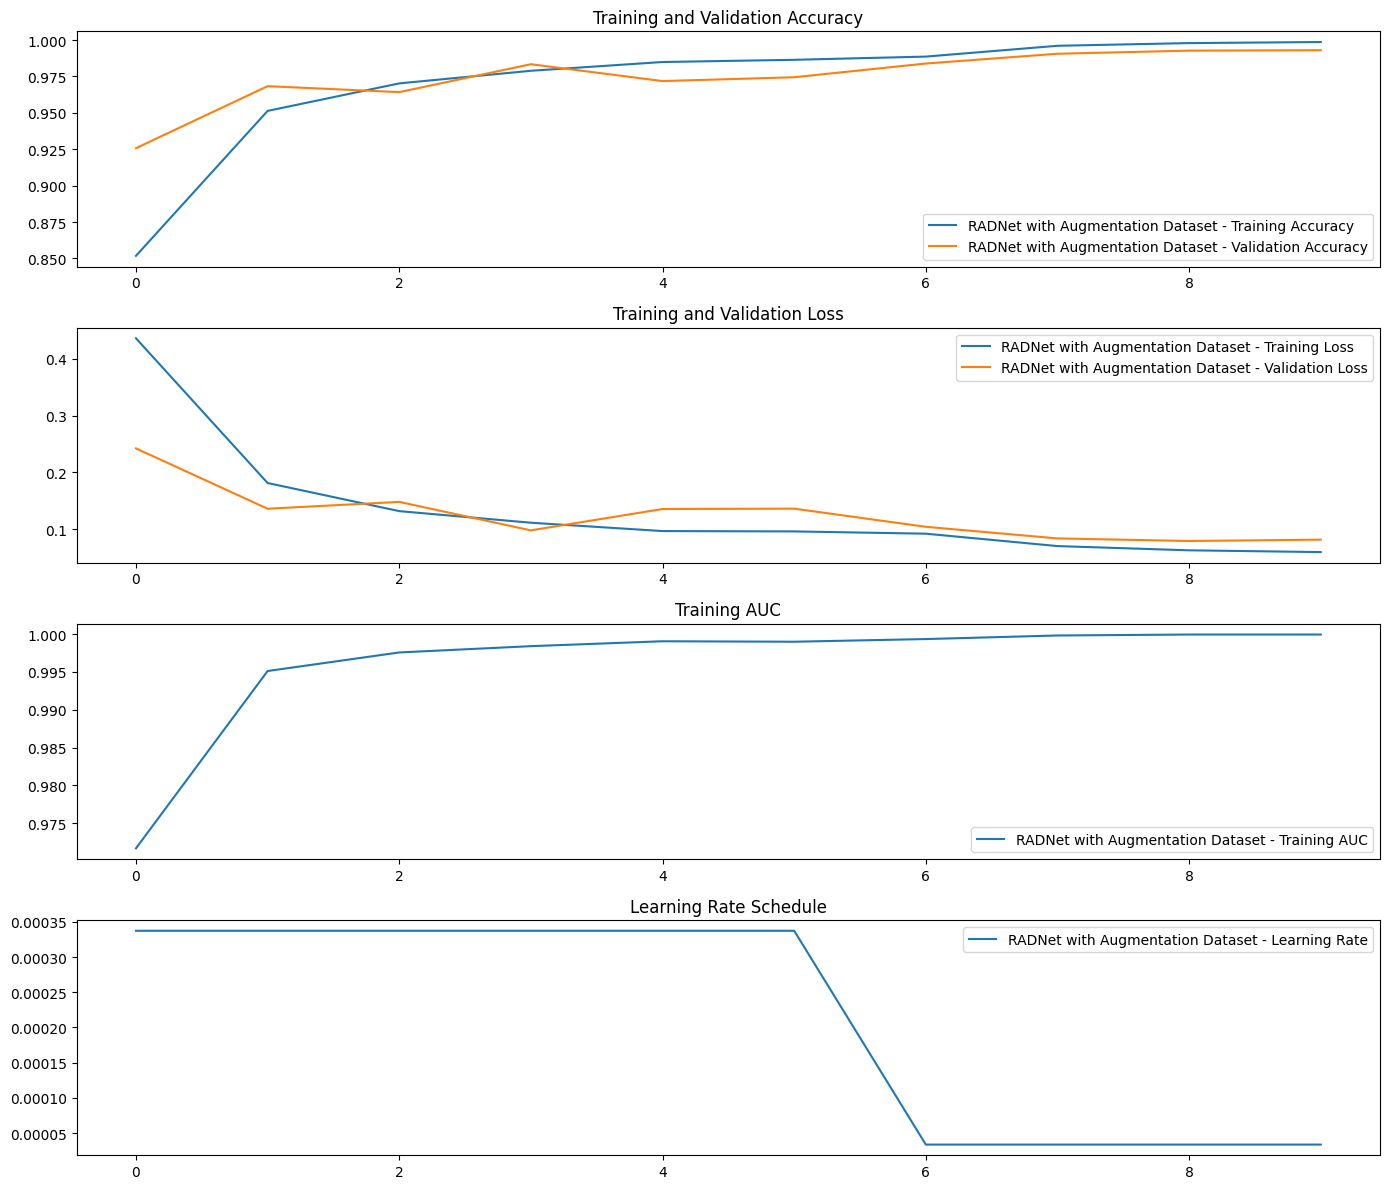

In [45]:
plot_combined_history([history_large_radnet], ["RADNet with Augmentation Dataset"])

In [46]:
print('RADNet Model Large:')
radnet_model_large.summary()

RADNet Model Large:


Model: "RADNet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 3, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 3, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 128)           │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,395,086 (85.43 MB)

 Trainable params: 2,559,620 (9.76 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

 Optimizer params: 5,119,242 (19.53 MB)

In [47]:
# Save RADNet model after training on large dataset
radnet_model_large.save('radnet_model_large_trained.keras')

#### Small Dataset

In [48]:
radnet_model_small = tuner_radnet.hypermodel.build(best_hps_radnet)

In [49]:
%%time

# Train RADNet model on small dataset
radnet_model_small = tuner_radnet.hypermodel.build(best_hps_radnet)
history_small_radnet = train_small_dataset(
    radnet_model_small, new_X_train_r, new_Y_train_r, new_X_test_r, new_Y_test_r,
    batch_size, epochs_small, checkpoint_file='radnet_model_small.keras',class_weights=class_weights)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - AUC: 0.7447 - accuracy: 0.5047 - loss: 1.2059
Epoch 1: val_loss improved from inf to 0.67504, saving model to radnet_model_small.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Epoch 1: precision=0.8562, recall=0.7354, f1=0.7509
Epoch 1: Learning rate is 0.000337
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - AUC: 0.7459 - accuracy: 0.5061 - loss: 1.2031 - val_AUC: 0.9281 - val_accuracy: 0.7626 - val_loss: 0.6750 - learning_rate: 3.3725e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9671 - accuracy: 0.8420 - loss: 0.4690
Epoch 2: val_loss improved from 0.67504 to 0.41078, saving model to radnet_model_small.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 2: precision=0.8760, recall=0.8688, f1=0.8684
Epoch 2: Learning rate is 0.000337
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 0.9671 - accuracy: 0.8421 - loss: 0.4687 - val_AUC: 0.9762 - val_accuracy: 0.8683 - val_loss: 0.4108 - learning_rate: 3.3725e-04
Epoch 3/10
9

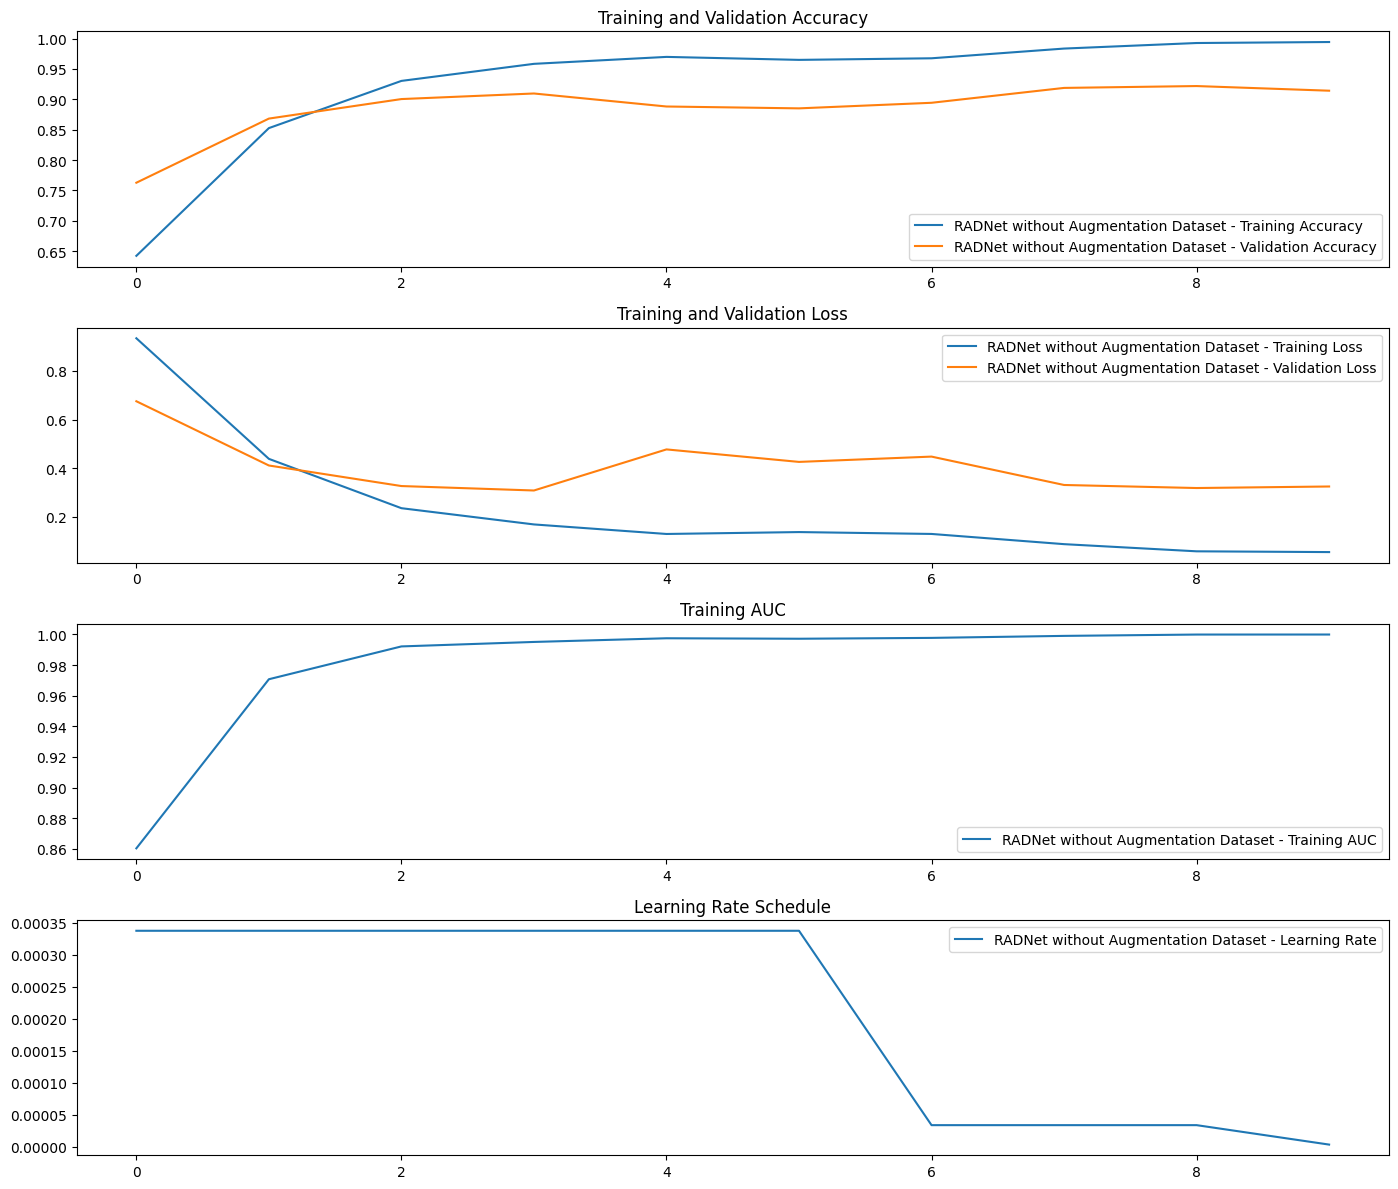

In [50]:
plot_combined_history([history_small_radnet], ["RADNet without Augmentation Dataset"])

In [51]:
print('RADNet Model Small Summary:')
radnet_model_small.summary()

RADNet Model Small Summary:


Model: "RADNet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 3, 3, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 1, 1, 128)           │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,395,086 (85.43 MB)

 Trainable params: 2,559,620 (9.76 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

 Optimizer params: 5,119,242 (19.53 MB)

In [52]:
# Save RADNet model after training on small dataset
radnet_model_small.save('radnet_model_small_trained.keras')

#### RADNet Model: Comparison of Large and Small Dataset

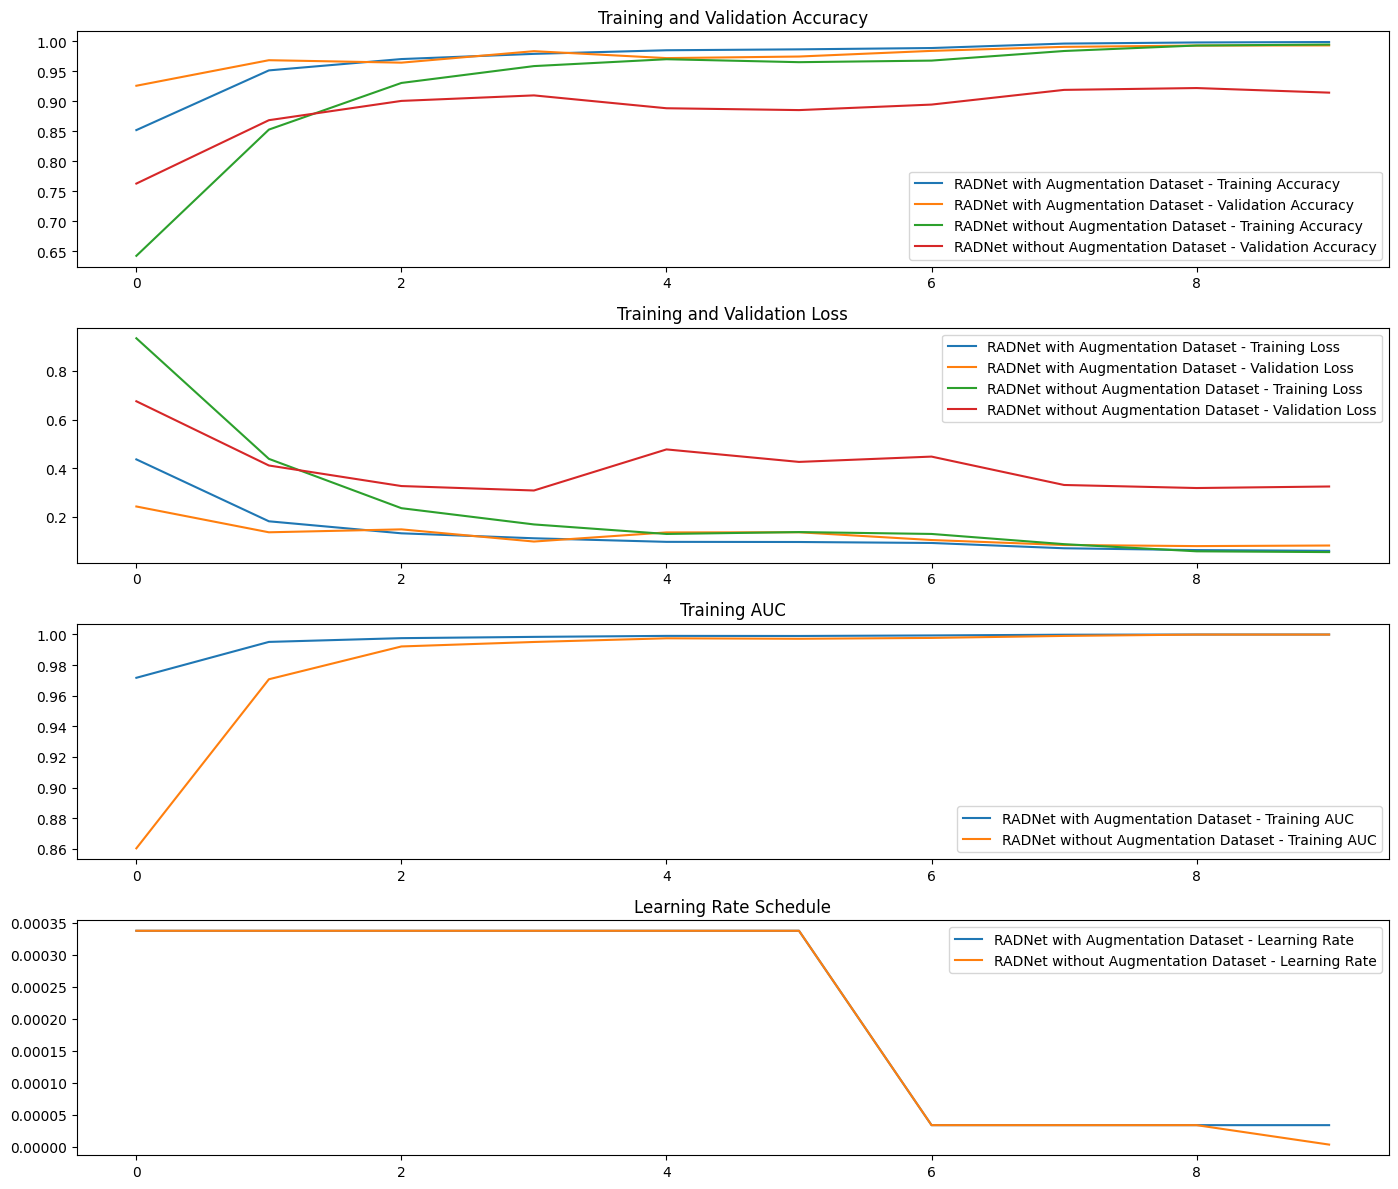

In [53]:
histories = [history_large_radnet, history_small_radnet]
titles = ["RADNet with Augmentation Dataset", "RADNet without Augmentation Dataset"]
plot_combined_history(histories, titles)

#### ViT Model

In [54]:
# Function for ViT

input_shape = (224, 224, 3)
batch_size = 32
epochs_large = 10
epochs_small = 10

In [55]:
vit_model_large = tuner_vit.hypermodel.build(best_hps_vit)
print("ViT Model Summary:")
vit_model_large.summary()

ViT Model Summary:


Model: "ViT_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_feature_extractor               │ (None, 197, 768)            │               0 │
│ (ViTFeatureExtractor)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 768)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,684 (1.01 MB)

 Trainable params: 263,684 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

#### Large Dataset

In [56]:
%%time

# Train ViT model on large dataset
history_large_vit = train_large_dataset(
    vit_model_large, new_X_train, new_Y_train, new_X_test, new_Y_test,
    batch_size, epochs_large, checkpoint_file='vit_model_large.keras', class_weights=class_weights)

Epoch 1/10
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.6934 - accuracy: 0.4348 - loss: 1.2426
Epoch 1: val_loss improved from inf to 0.74600, saving model to vit_model_large.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step
Epoch 1: precision=0.7152, recall=0.7191, f1=0.7130
Epoch 1: Learning rate is 0.000014
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 127s 75ms/step - AUC: 0.6935 - accuracy: 0.4349 - loss: 1.2425 - val_AUC: 0.9160 - val_accuracy: 0.7173 - val_loss: 0.7460 - learning_rate: 1.4319e-05
Epoch 2/10
1317/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.8952 - accuracy: 0.6874 - loss: 0.7914
Epoch 2: val_loss improved from 0.74600 to 0.58472, saving model to vit_model_large.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Epoch 2: precision=0.7814, recall=0.7849, f1=0.7812
Epoch 2: Learning rate is 0.000014
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - AUC: 0.8952 - accuracy: 0.6875 - loss: 0.7913 - val_AUC: 0.9459 - val_accuracy: 0.7833 - val_loss: 0.5847 - learning_rate: 1.4319e

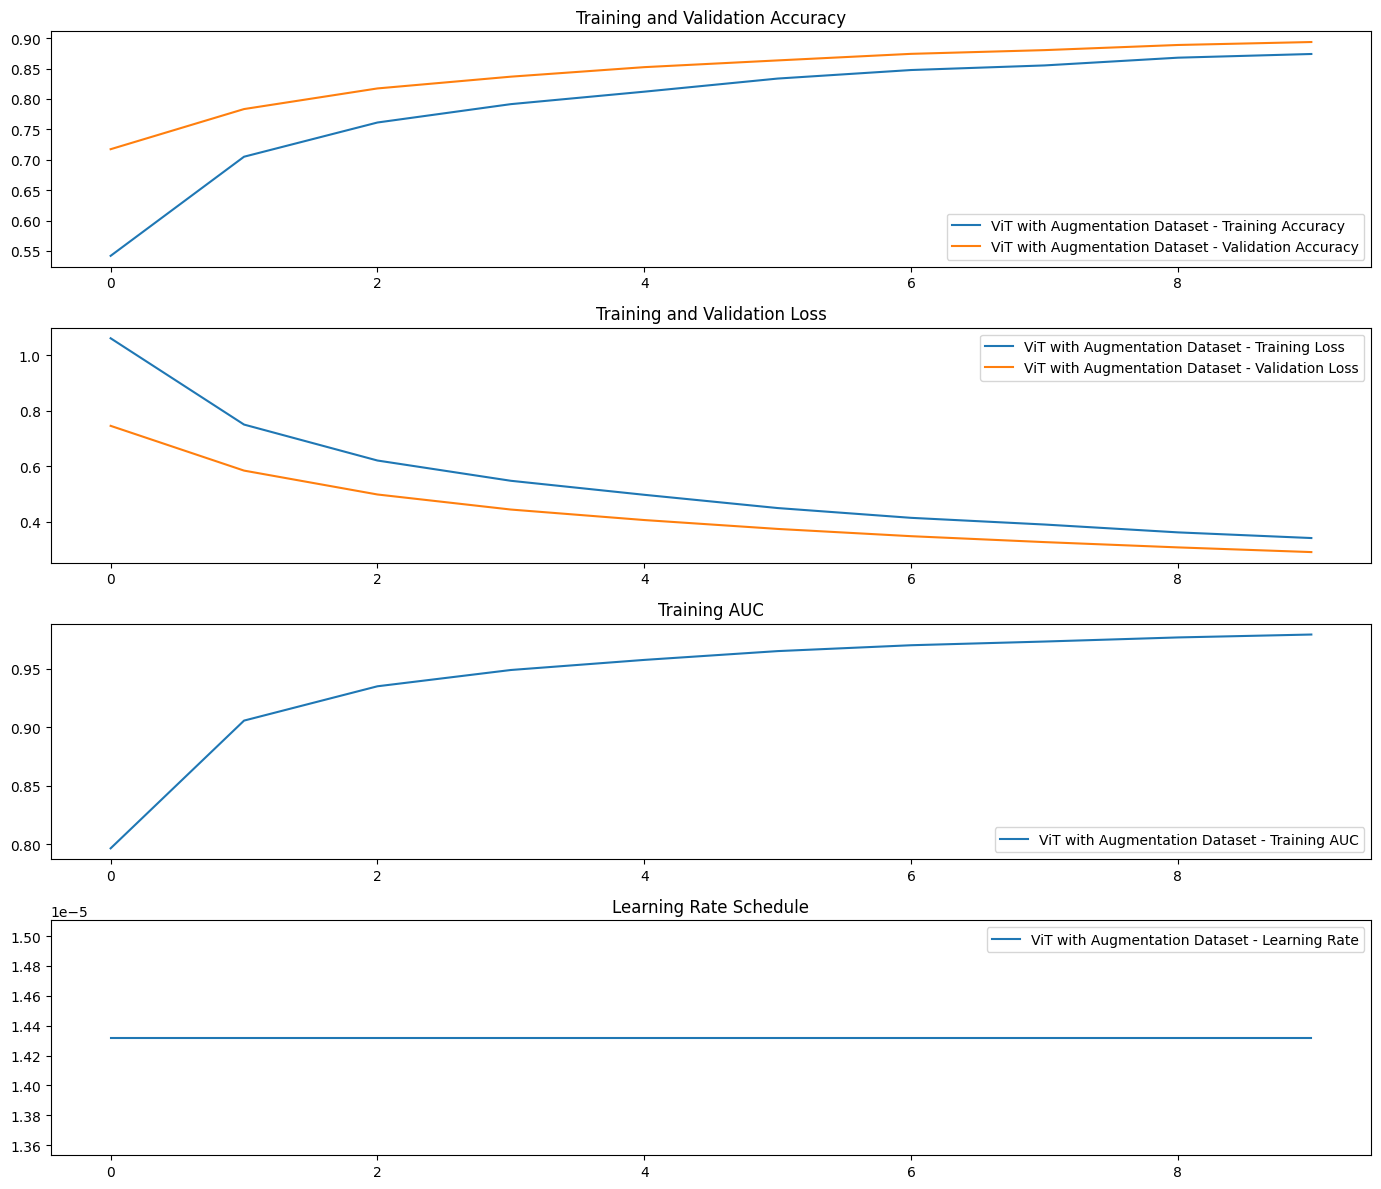

In [57]:
plot_combined_history([history_large_vit], ["ViT with Augmentation Dataset"])

In [58]:
print("ViT Model Large Summary:")
vit_model_large.summary()

ViT Model Large Summary:


Model: "ViT_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_feature_extractor               │ (None, 197, 768)            │               0 │
│ (ViTFeatureExtractor)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 768)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 791,054 (3.02 MB)

 Trainable params: 263,684 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 527,370 (2.01 MB)

In [59]:
# Save ViT model after training on large dataset
vit_model_large.save('vit_model_large_trained.keras')

#### Small Dataset

In [60]:
vit_model_small = tuner_vit.hypermodel.build(best_hps_vit)

In [61]:
%%time

# Train ViT model on small dataset
vit_model_small = tuner_vit.hypermodel.build(best_hps_vit)
history_small_vit = train_small_dataset(
    vit_model_small, new_X_train_r, new_Y_train_r, new_X_test_r, new_Y_test_r,
    batch_size, epochs_small, checkpoint_file='vit_model_small.keras',class_weights=class_weights)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - AUC: 0.4869 - accuracy: 0.2260 - loss: 1.6647
Epoch 1: val_loss improved from inf to 1.30940, saving model to vit_model_small.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step
Epoch 1: precision=0.3968, recall=0.4206, f1=0.3825
Epoch 1: Learning rate is 0.000014
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 484ms/step - AUC: 0.4871 - accuracy: 0.2262 - loss: 1.6638 - val_AUC: 0.6671 - val_accuracy: 0.4074 - val_loss: 1.3094 - learning_rate: 1.4319e-05
Epoch 2/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.6040 - accuracy: 0.3285 - loss: 1.3791
Epoch 2: val_loss improved from 1.30940 to 1.18701, saving model to vit_model_small.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 2: precision=0.5516, recall=0.5616, f1=0.5296
Epoch 2: Learning rate is 0.000014
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.6045 - accuracy: 0.3292 - loss: 1.3784 - val_AUC: 0.7858 - val_accuracy: 0.5574 - val_loss: 1.1870 - learning_rate: 1.4319e-05
Epoch 3/10
95/9

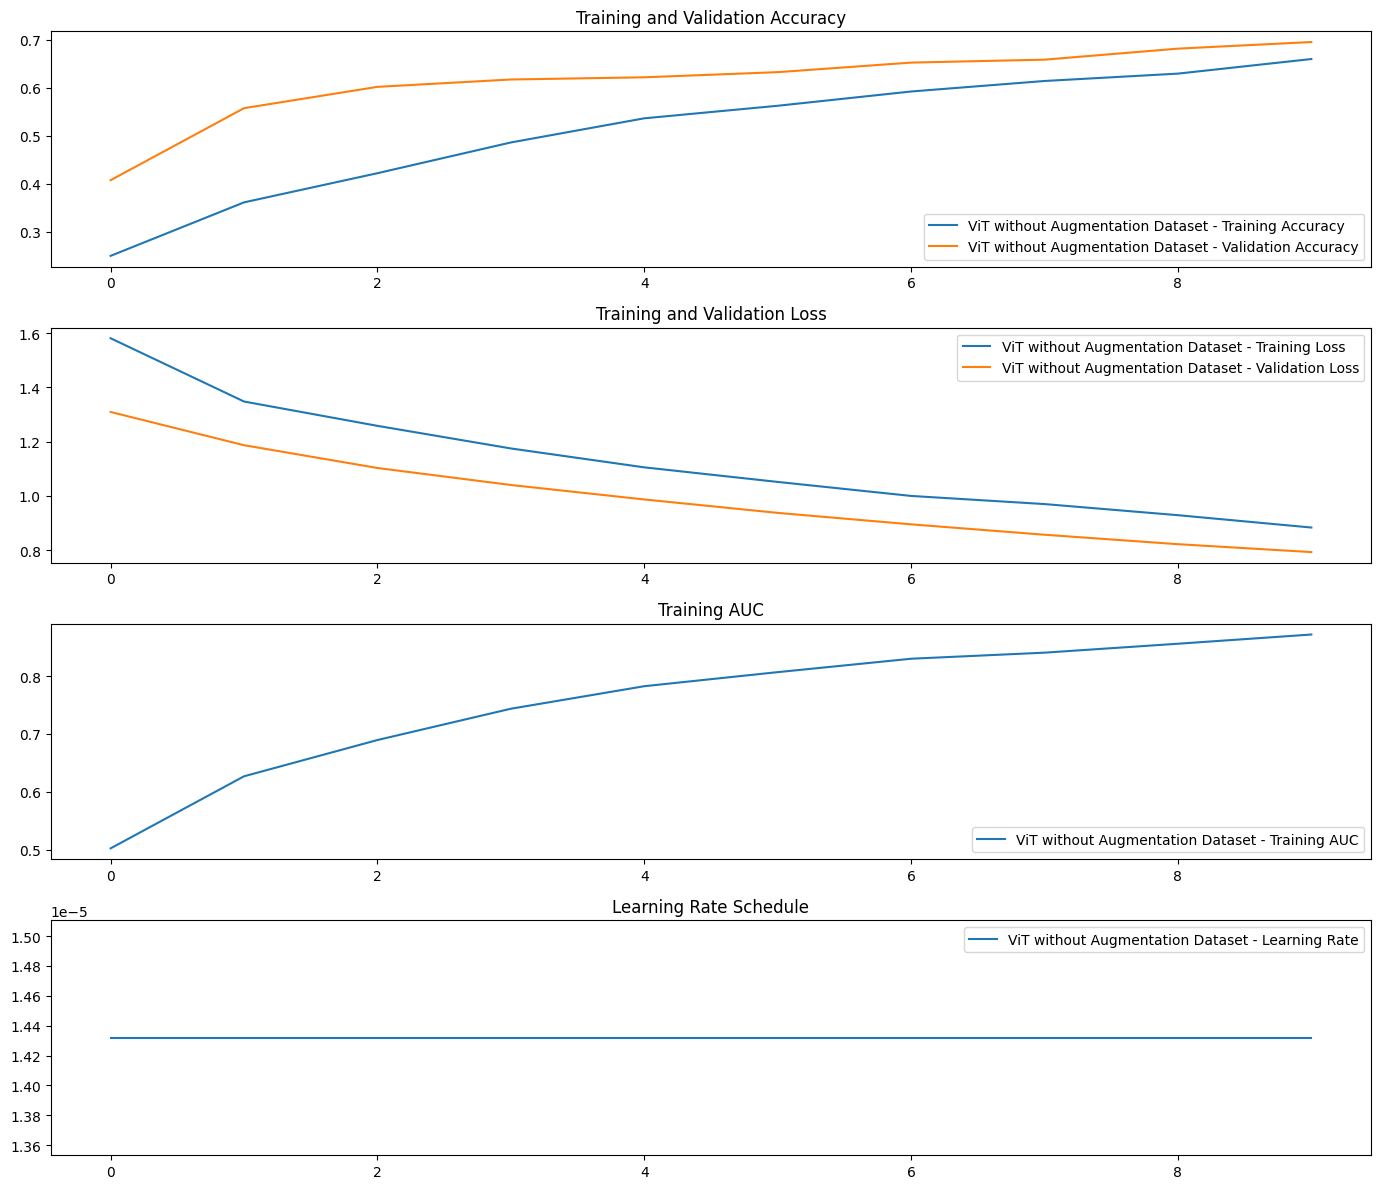

In [62]:
plot_combined_history([history_small_vit], ["ViT without Augmentation Dataset"])

In [63]:
print('ViT Model Small Summary:')
vit_model_small.summary()

ViT Model Small Summary:


Model: "ViT_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_feature_extractor_2             │ (None, 197, 768)            │               0 │
│ (ViTFeatureExtractor)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 768)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 791,054 (3.02 MB)

 Trainable params: 263,684 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 527,370 (2.01 MB)

In [64]:
# Save ViT model after training on small dataset
vit_model_small.save('vit_model_small_trained.keras')

#### ViT Model: Comparison of Large and Small Dataset



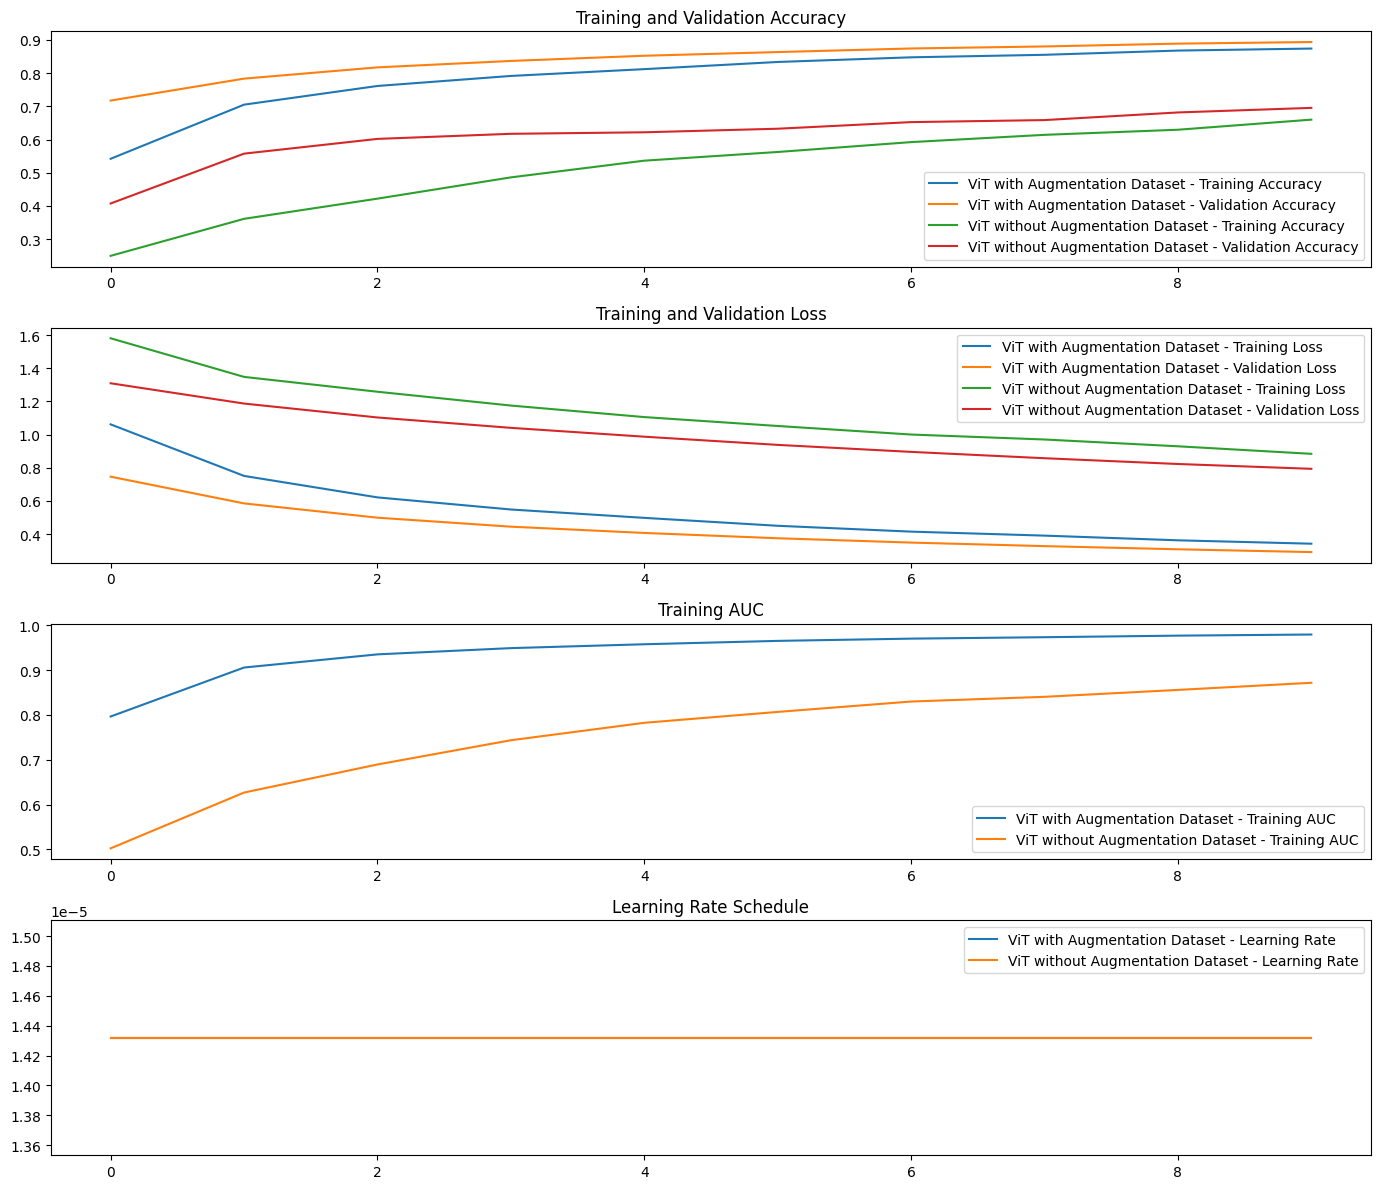

In [65]:
histories = [history_large_vit, history_small_vit]
titles = ["ViT with Augmentation Dataset", "ViT without Augmentation Dataset"]
plot_combined_history(histories, titles)

#### Evaluate Models: RADNet and ViT Models

In [66]:
# Category names are in the same order as label mapping to ensure consistency of dataset

category_names = ["No Tumor", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

RADNet with Augmentation Dataset - Test Loss: 0.08157312124967575, Test Accuracy: 0.993000864982605, Test AUC: 0.9989409446716309
322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
RADNet with Augmentation Dataset - Precision: 0.99
RADNet with Augmentation Dataset - Recall: 0.99
RADNet with Augmentation Dataset - F1 Score: 0.99
RADNet with Augmentation Dataset - AUC: 1.00




Confusion Matrix:


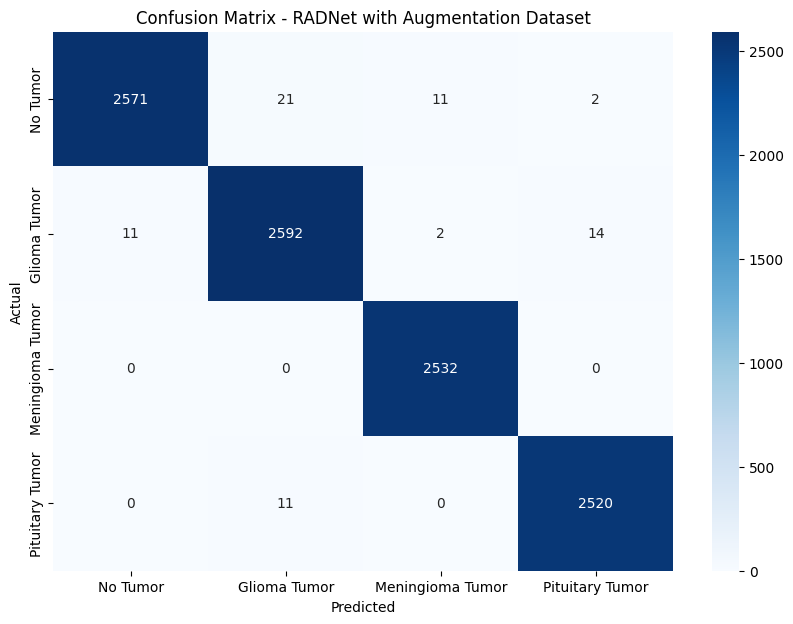





Classification Report:
                  precision    recall  f1-score   support

        No Tumor       1.00      0.99      0.99      2605
    Glioma Tumor       0.99      0.99      0.99      2619
Meningioma Tumor       0.99      1.00      1.00      2532
 Pituitary Tumor       0.99      1.00      0.99      2531

        accuracy                           0.99     10287
       macro avg       0.99      0.99      0.99     10287
    weighted avg       0.99      0.99      0.99     10287



RADNet without Augmentation Dataset - Test Loss: 0.32439541816711426, Test Accuracy: 0.9142419695854187, Test AUC: 0.9851942658424377
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RADNet without Augmentation Dataset - Precision: 0.92
RADNet without Augmentation Dataset - Recall: 0.91
RADNet without Augmentation Dataset - F1 Score: 0.92
RADNet without Augmentation Dataset - AUC: 0.99




Confusion Matrix:


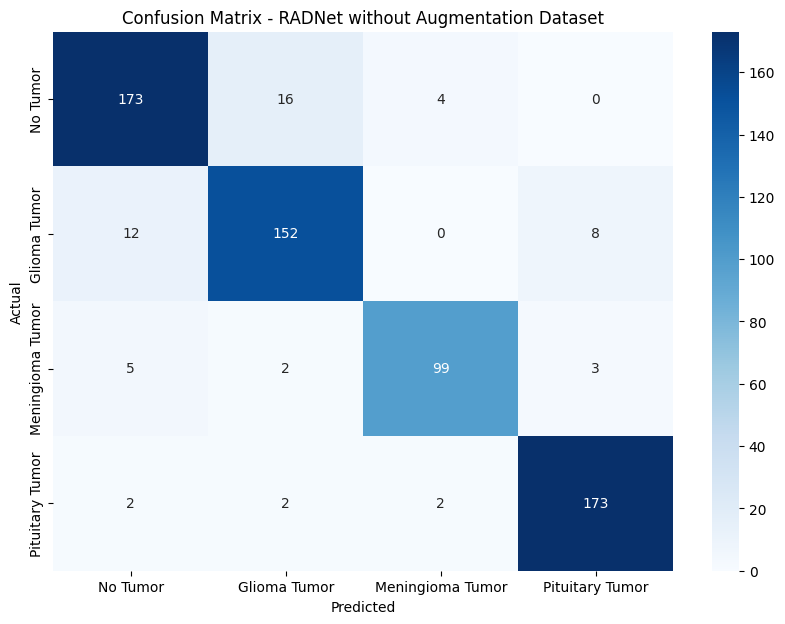





Classification Report:
                  precision    recall  f1-score   support

        No Tumor       0.90      0.90      0.90       193
    Glioma Tumor       0.88      0.88      0.88       172
Meningioma Tumor       0.94      0.91      0.93       109
 Pituitary Tumor       0.94      0.97      0.95       179

        accuracy                           0.91       653
       macro avg       0.92      0.91      0.92       653
    weighted avg       0.91      0.91      0.91       653



ViT with Augmentation Dataset - Test Loss: 0.29108747839927673, Test Accuracy: 0.8935549855232239, Test AUC: 0.9849587678909302
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
ViT with Augmentation Dataset - Precision: 0.89
ViT with Augmentation Dataset - Recall: 0.89
ViT with Augmentation Dataset - F1 Score: 0.89
ViT with Augmentation Dataset - AUC: 0.98




Confusion Matrix:


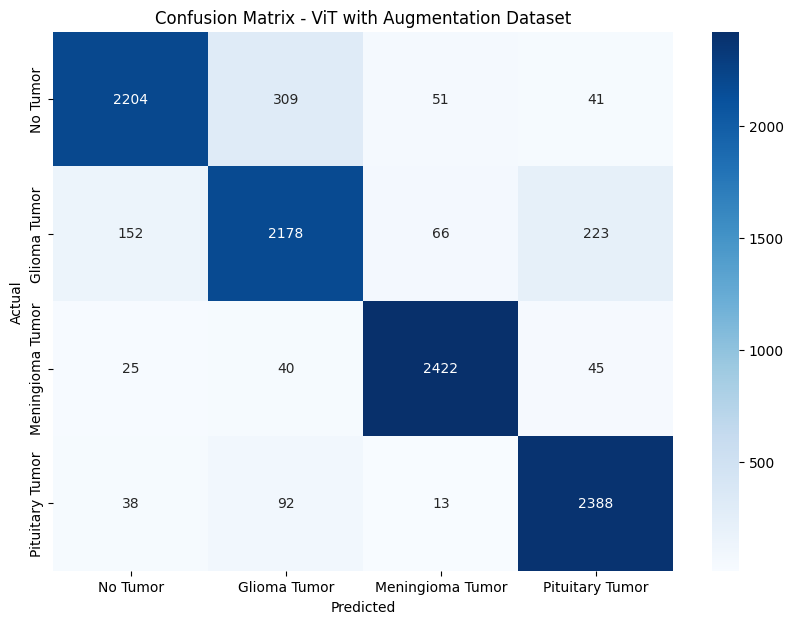





Classification Report:
                  precision    recall  f1-score   support

        No Tumor       0.91      0.85      0.88      2605
    Glioma Tumor       0.83      0.83      0.83      2619
Meningioma Tumor       0.95      0.96      0.95      2532
 Pituitary Tumor       0.89      0.94      0.91      2531

        accuracy                           0.89     10287
       macro avg       0.89      0.89      0.89     10287
    weighted avg       0.89      0.89      0.89     10287



ViT without Augmentation Dataset - Test Loss: 0.7933716177940369, Test Accuracy: 0.6952526569366455, Test AUC: 0.9121074080467224
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ViT without Augmentation Dataset - Precision: 0.69
ViT without Augmentation Dataset - Recall: 0.70
ViT without Augmentation Dataset - F1 Score: 0.68
ViT without Augmentation Dataset - AUC: 0.91




Confusion Matrix:


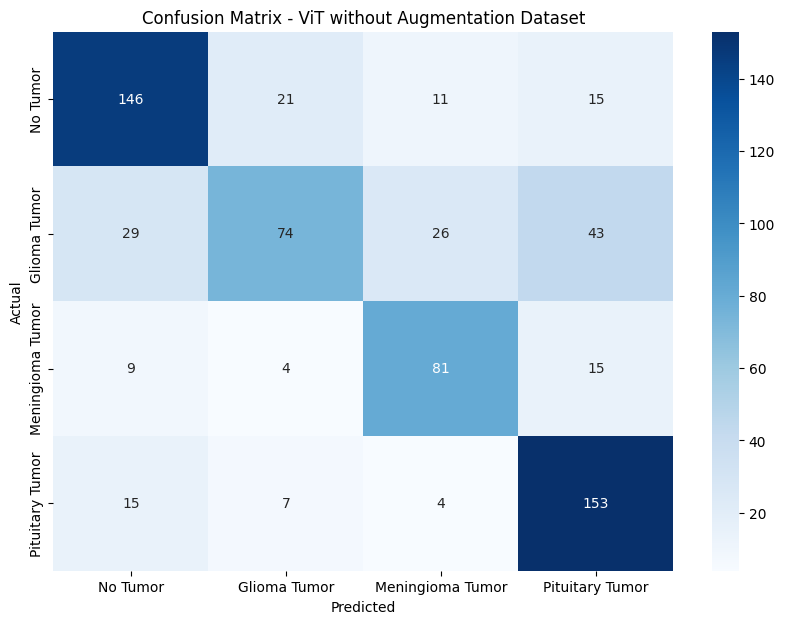





Classification Report:
                  precision    recall  f1-score   support

        No Tumor       0.73      0.76      0.74       193
    Glioma Tumor       0.70      0.43      0.53       172
Meningioma Tumor       0.66      0.74      0.70       109
 Pituitary Tumor       0.68      0.85      0.76       179

        accuracy                           0.70       653
       macro avg       0.69      0.70      0.68       653
    weighted avg       0.70      0.70      0.68       653



In [67]:
# Evaluate models
evaluate_model(radnet_model_large, new_X_test, new_Y_test, "RADNet with Augmentation Dataset", category_names)
print()
print()
evaluate_model(radnet_model_small, new_X_test_r, new_Y_test_r, "RADNet without Augmentation Dataset", category_names)
print()
print()
evaluate_model(vit_model_large, new_X_test, new_Y_test, "ViT with Augmentation Dataset", category_names)
print()
print()
evaluate_model(vit_model_small, new_X_test_r, new_Y_test_r, "ViT without Augmentation Dataset", category_names)

#### Comparison of RADNet Model and ViT Models

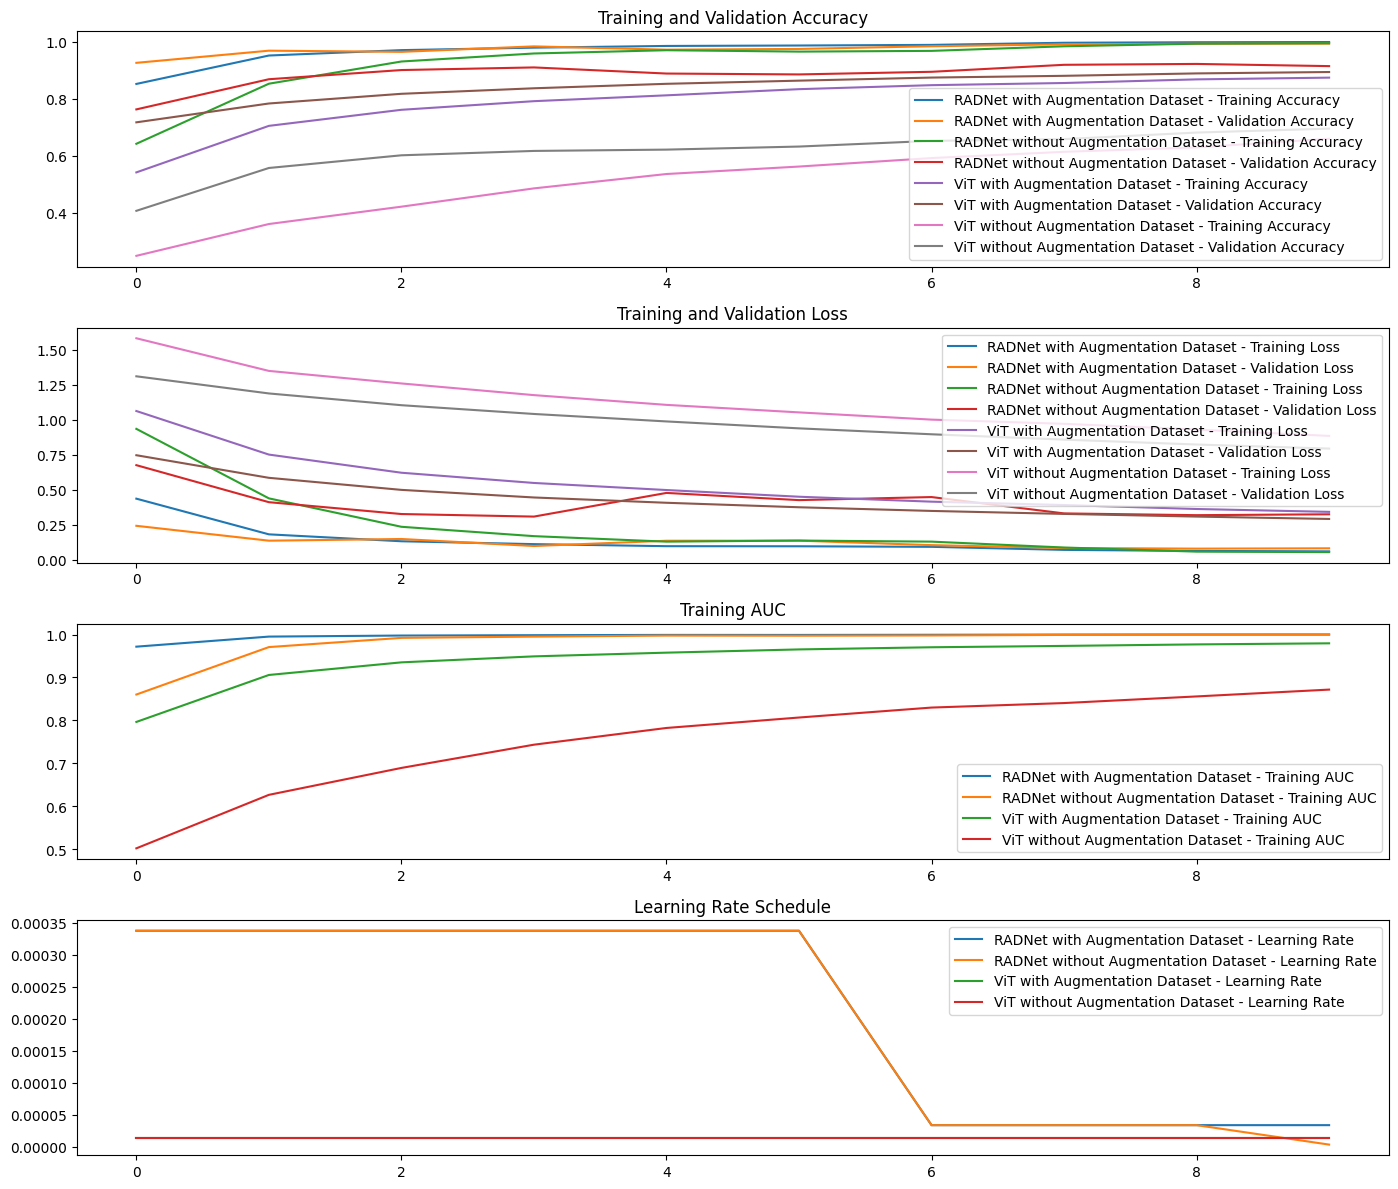

In [68]:
histories = [history_large_radnet, history_small_radnet, history_large_vit, history_small_vit]
titles = ["RADNet with Augmentation Dataset", "RADNet without Augmentation Dataset", "ViT with Augmentation Dataset", "ViT without Augmentation Dataset"]
plot_combined_history(histories, titles)

#### Hybrid Model: RADNet and ViT

In [69]:
# Function for Hybrid

input_shape = (224, 224, 3)
batch_size = 32
epochs_large = 10
epochs_small = 10

In [70]:
# Build the hybrid model using the best hyperparameters
hybrid_model_large = build_hybrid_model_with_best_hps()

In [71]:
print("Hybrid Model Summary:")
hybrid_model_large.summary()

Hybrid Model Summary:


Model: "Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 7, 7, 256)      │      1,179,904 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 7, 7, 256)      │          1,024 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 3, 3, 256)      │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 3, 3, 384)      │        885,120 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 3, 3, 384)      │          1,536 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 1, 1, 384)      │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 1, 1, 128)      │        442,496 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 1, 1, 128)      │            512 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vi_t_feature_extractor_3  │ (None, 197, 768)       │              0 │ input_layer_9[0][0]    │
│ (ViTFeatureExtractor)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ vi_t_feature_extracto… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 256)            │        196,864 │ global_average_poolin… │
├──────────────────────

 Total params: 17,702,212 (67.53 MB)

 Trainable params: 2,985,988 (11.39 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

#### Large Dataset

In [72]:
%%time

# Train Hybrid model on large dataset
history_hybrid_large = train_large_dataset(
    hybrid_model_large, new_X_train, new_Y_train, new_X_test, new_Y_test, batch_size, epochs_large, checkpoint_file='hybrid_model_large.keras',class_weights=class_weights)

Epoch 1/10
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - AUC: 0.8413 - accuracy: 0.6141 - loss: 0.9203
Epoch 1: val_loss improved from inf to 0.23119, saving model to hybrid_model_large.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step
Epoch 1: precision=0.9296, recall=0.9296, f1=0.9281
Epoch 1: Learning rate is 0.000176
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 151s 93ms/step - AUC: 0.8414 - accuracy: 0.6142 - loss: 0.9200 - val_AUC: 0.9927 - val_accuracy: 0.9286 - val_loss: 0.2312 - learning_rate: 1.7579e-04
Epoch 2/10
1318/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - AUC: 0.9901 - accuracy: 0.9242 - loss: 0.2544
Epoch 2: val_loss improved from 0.23119 to 0.14722, saving model to hybrid_model_large.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
Epoch 2: precision=0.9602, recall=0.9599, f1=0.9597
Epoch 2: Learning rate is 0.000176
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 78s 59ms/step - AUC: 0.9901 - accuracy: 0.9242 - loss: 0.2543 - val_AUC: 0.9972 - val_accuracy: 0.9595 - val_loss: 0.1472 - learning_rate: 

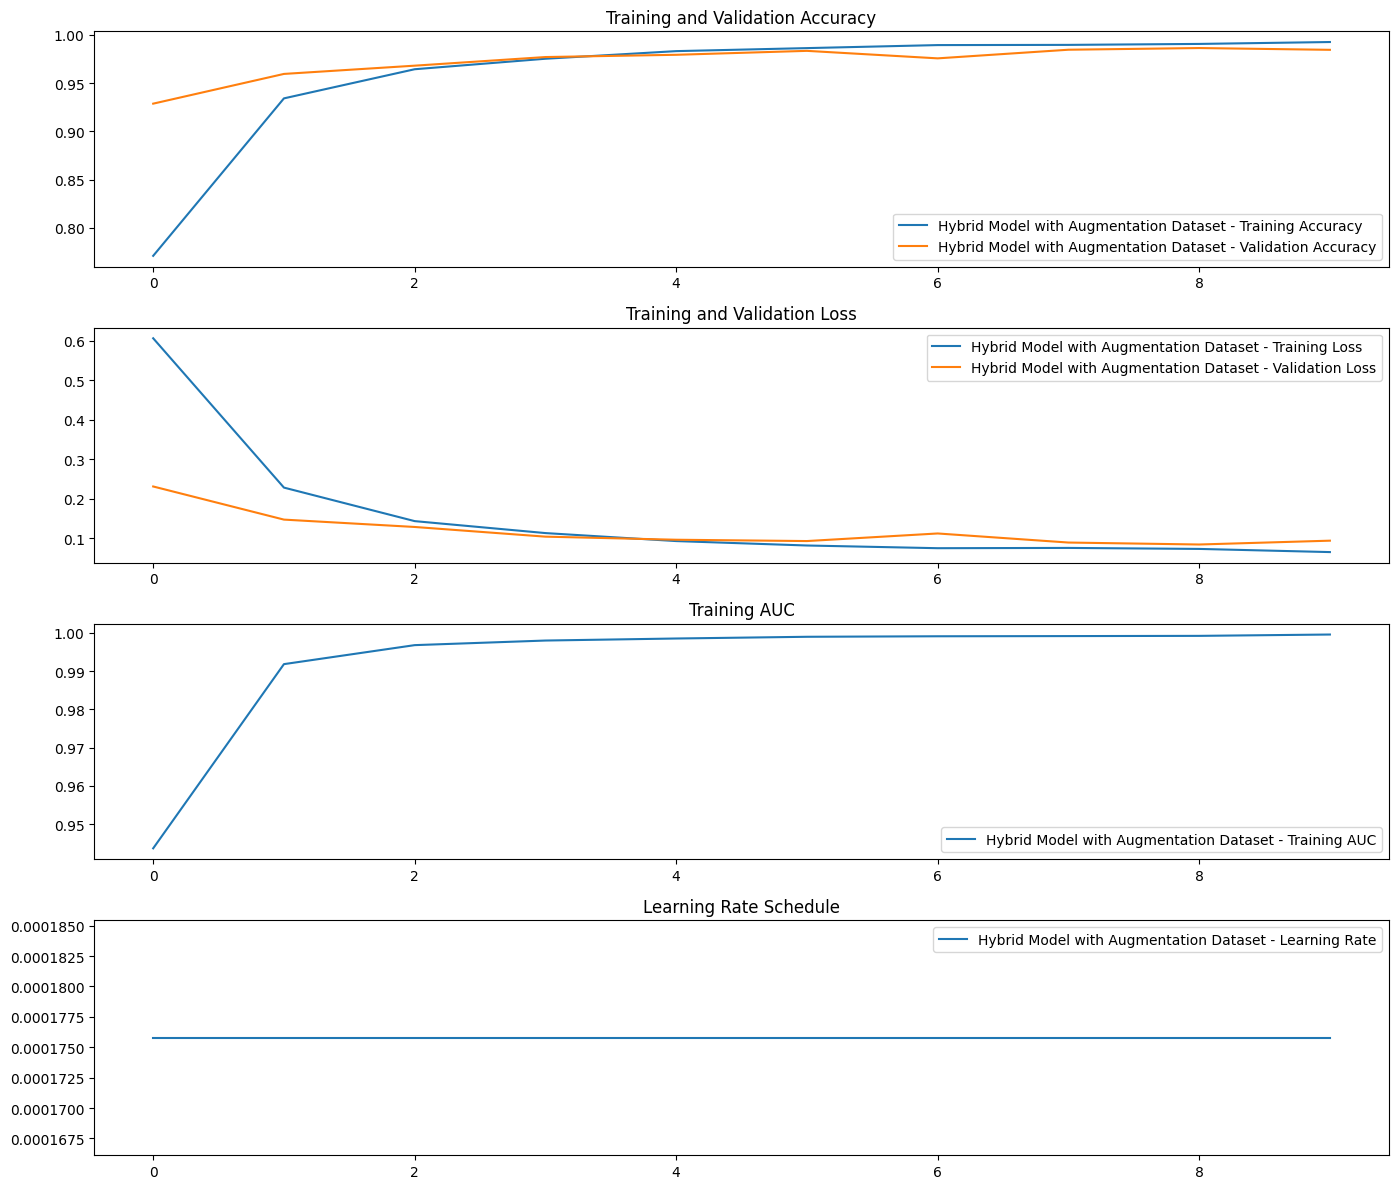

In [73]:
plot_combined_history([history_hybrid_large], ["Hybrid Model with Augmentation Dataset"])

In [74]:
print("Hybrid Model Large Summary:")
hybrid_model_large.summary()

Hybrid Model Large Summary:


Model: "Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 7, 7, 256)      │      1,179,904 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 7, 7, 256)      │          1,024 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 3, 3, 256)      │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 3, 3, 384)      │        885,120 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 3, 3, 384)      │          1,536 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 1, 1, 384)      │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 1, 1, 128)      │        442,496 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 1, 1, 128)      │            512 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vi_t_feature_extractor_3  │ (None, 197, 768)       │              0 │ input_layer_9[0][0]    │
│ (ViTFeatureExtractor)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ vi_t_feature_extracto… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 256)            │        196,864 │ global_average_poolin… │
├──────────────────────

 Total params: 23,674,190 (90.31 MB)

 Trainable params: 2,985,988 (11.39 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

 Optimizer params: 5,971,978 (22.78 MB)

In [75]:
# Save Hybrid model after training on large dataset
hybrid_model_large.save('hybrid_model_large_trained.keras')

#### Small Dataset

In [76]:
# Build the hybrid model using the best hyperparameters
hybrid_model_small = build_hybrid_model_with_best_hps()

In [77]:
%%time

# Train Hybrid model on small dataset
hybrid_model_small = build_hybrid_model_with_best_hps()
history_hybrid_small = train_small_dataset(
    hybrid_model_small, new_X_train_r, new_Y_train_r, new_X_test_r, new_Y_test_r, batch_size, epochs_small, checkpoint_file='hybrid_model_small.keras',class_weights=class_weights)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - AUC: 0.5665 - accuracy: 0.3134 - loss: 1.5393
Epoch 1: val_loss improved from inf to 1.11832, saving model to hybrid_model_small.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 402ms/step
Epoch 1: precision=0.6431, recall=0.6238, f1=0.6067
Epoch 1: Learning rate is 0.000176
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 569ms/step - AUC: 0.5673 - accuracy: 0.3140 - loss: 1.5378 - val_AUC: 0.8580 - val_accuracy: 0.6172 - val_loss: 1.1183 - learning_rate: 1.7579e-04
Epoch 2/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - AUC: 0.8251 - accuracy: 0.5782 - loss: 1.0276
Epoch 2: val_loss improved from 1.11832 to 0.62183, saving model to hybrid_model_small.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 2: precision=0.8367, recall=0.8142, f1=0.8162
Epoch 2: Learning rate is 0.000176
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - AUC: 0.8258 - accuracy: 0.5792 - loss: 1.0256 - val_AUC: 0.9553 - val_accuracy: 0.8086 - val_loss: 0.6218 - learning_rate: 1.7579e-04
Epoch 3/1

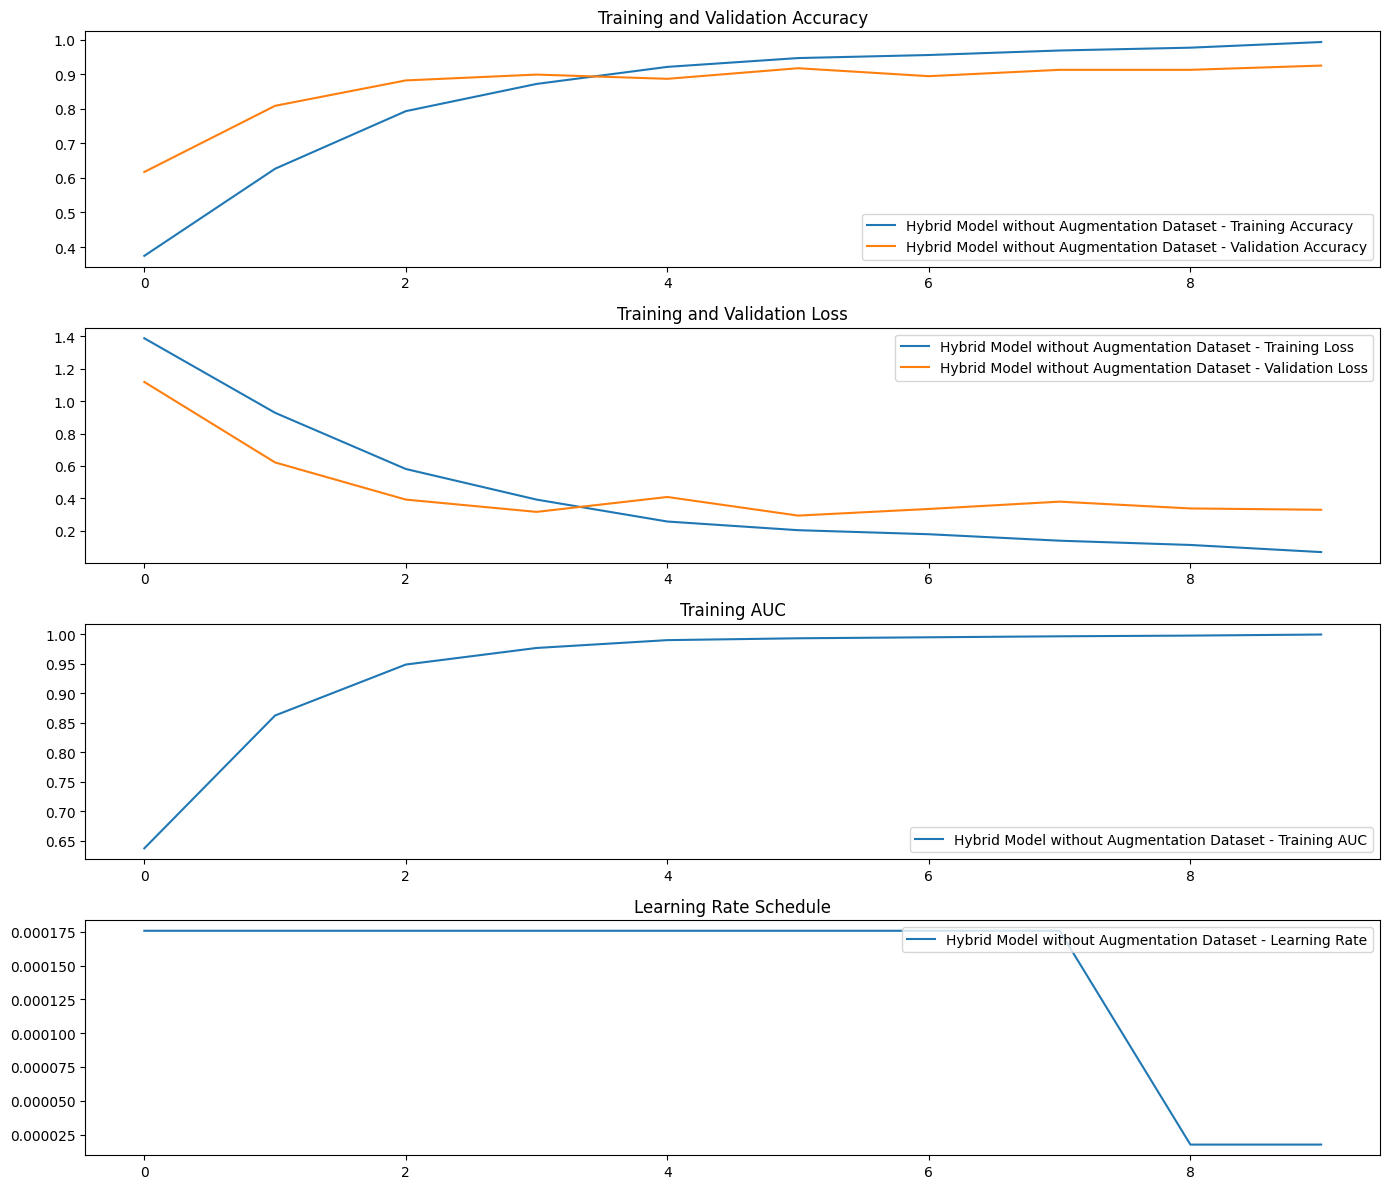

In [78]:
plot_combined_history([history_hybrid_small], ["Hybrid Model without Augmentation Dataset"])

In [79]:
print("Hybrid Model Small Summary:")
hybrid_model_small.summary()

Hybrid Model Small Summary:


Model: "Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 7, 7, 256)      │      1,179,904 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 7, 7, 256)      │          1,024 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 3, 3, 256)      │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 3, 3, 384)      │        885,120 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 3, 3, 384)      │          1,536 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 1, 1, 384)      │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 1, 1, 128)      │        442,496 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 1, 1, 128)      │            512 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vi_t_feature_extractor_5  │ (None, 197, 768)       │              0 │ input_layer_13[0][0]   │
│ (ViTFeatureExtractor)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ vi_t_feature_extracto… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 256)            │        196,864 │ global_average_poolin… │
├──────────────────────

 Total params: 23,674,190 (90.31 MB)

 Trainable params: 2,985,988 (11.39 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

 Optimizer params: 5,971,978 (22.78 MB)

In [80]:
# Save Hybrid model after training on small dataset
hybrid_model_small.save('hybrid_model_small_trained.keras')

#### Hybrid Model: Comparison of Large and Small Dataset

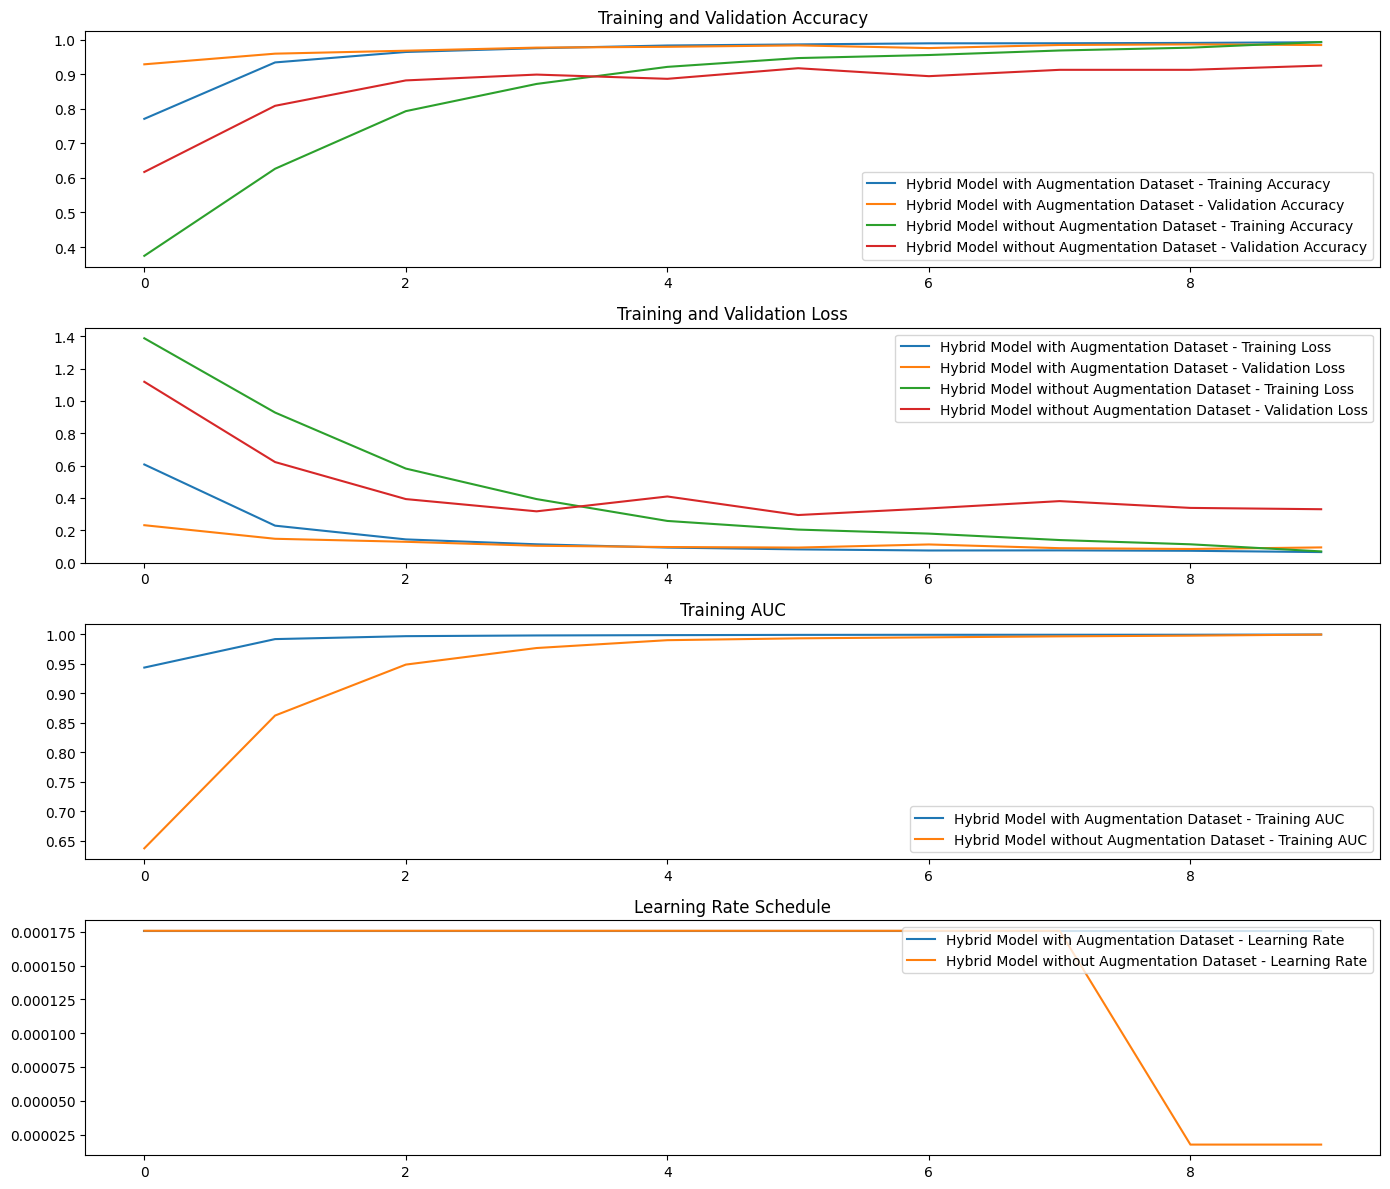

In [81]:
histories = [history_hybrid_large, history_hybrid_small]
titles = ["Hybrid Model with Augmentation Dataset", "Hybrid Model without Augmentation Dataset"]
plot_combined_history(histories, titles)

### Comparison of Models: Dataset with Augmentation

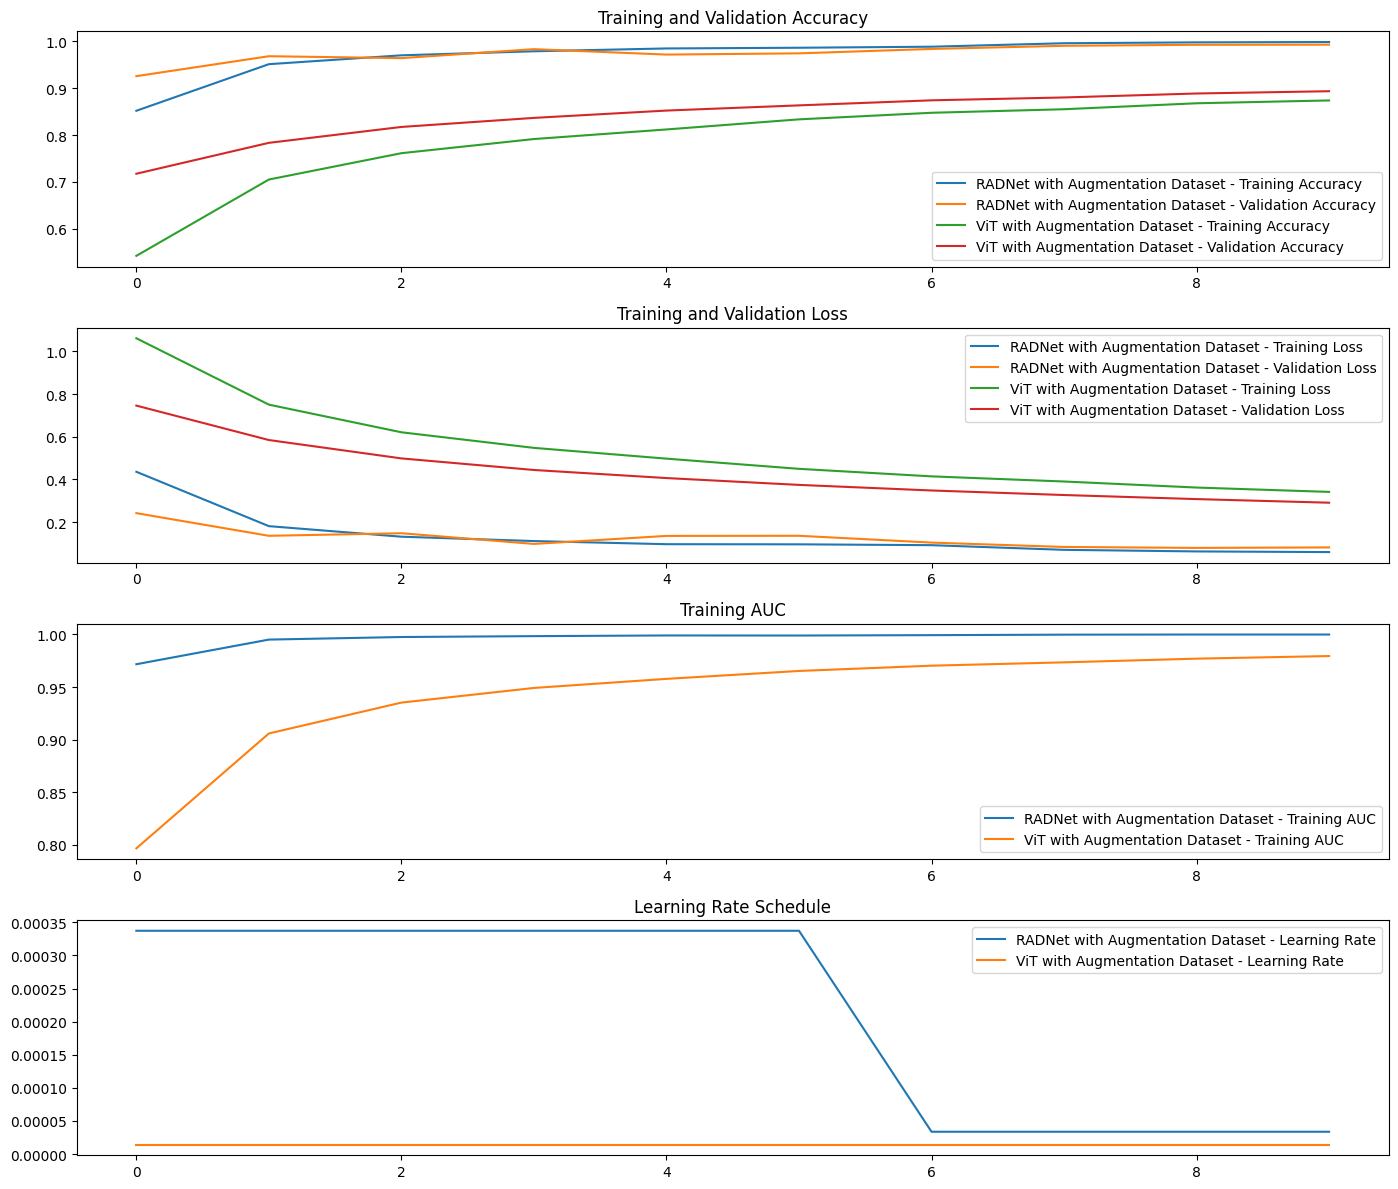

In [82]:
histories = [history_large_radnet, history_large_vit]
titles = ["RADNet with Augmentation Dataset", "ViT with Augmentation Dataset"]
plot_combined_history(histories, titles)

#### Evaluate Model: Hybrid Model

Hybrid Model with Augmentation Dataset - Test Loss: 0.09381332248449326, Test Accuracy: 0.9844464063644409, Test AUC: 0.9983378052711487
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
Hybrid Model with Augmentation Dataset - Precision: 0.98
Hybrid Model with Augmentation Dataset - Recall: 0.98
Hybrid Model with Augmentation Dataset - F1 Score: 0.98
Hybrid Model with Augmentation Dataset - AUC: 1.00




Confusion Matrix:


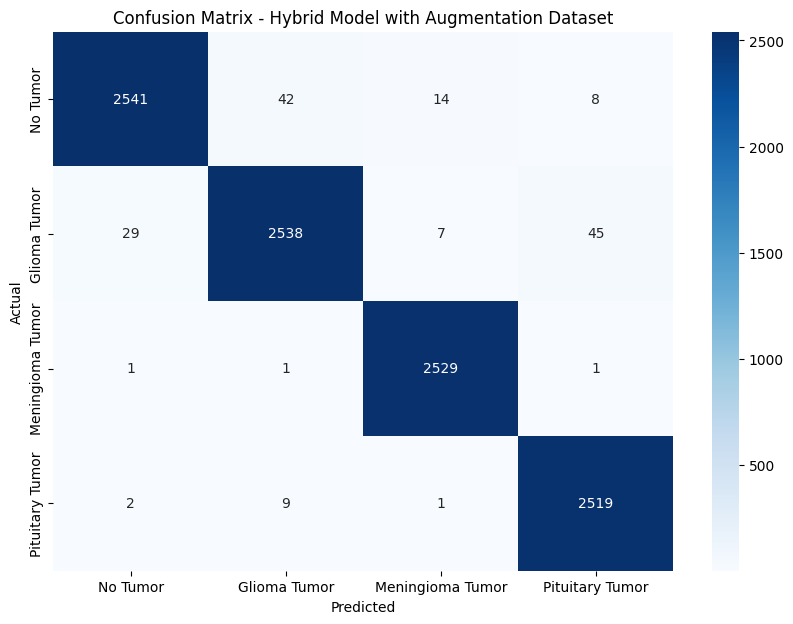





Classification Report:
                  precision    recall  f1-score   support

        No Tumor       0.99      0.98      0.98      2605
    Glioma Tumor       0.98      0.97      0.97      2619
Meningioma Tumor       0.99      1.00      1.00      2532
 Pituitary Tumor       0.98      1.00      0.99      2531

        accuracy                           0.98     10287
       macro avg       0.98      0.98      0.98     10287
    weighted avg       0.98      0.98      0.98     10287



Hybrid Model without Augmentation Dataset - Test Loss: 0.33005157113075256, Test Accuracy: 0.9249616861343384, Test AUC: 0.9820090532302856
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Hybrid Model without Augmentation Dataset - Precision: 0.93
Hybrid Model without Augmentation Dataset - Recall: 0.92
Hybrid Model without Augmentation Dataset - F1 Score: 0.93
Hybrid Model without Augmentation Dataset - AUC: 0.99




Confusion Matrix:


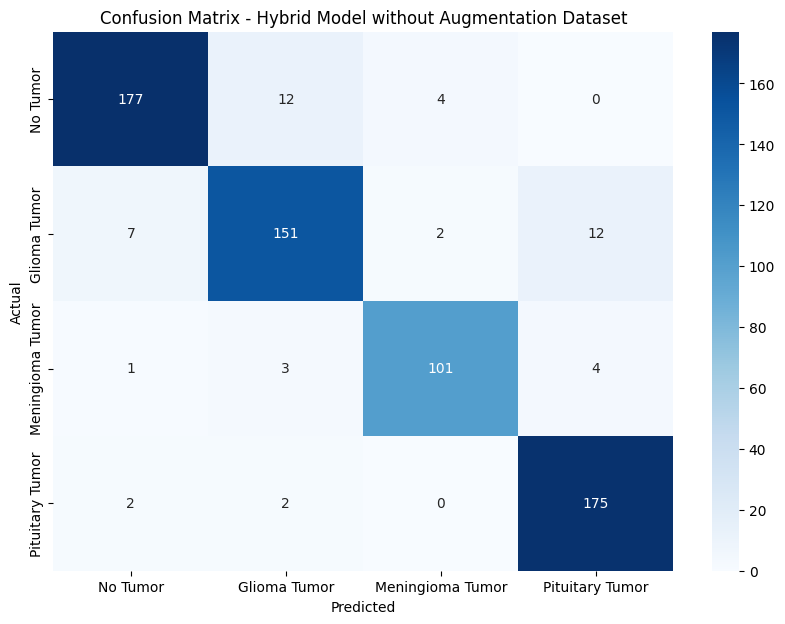





Classification Report:
                  precision    recall  f1-score   support

        No Tumor       0.95      0.92      0.93       193
    Glioma Tumor       0.90      0.88      0.89       172
Meningioma Tumor       0.94      0.93      0.94       109
 Pituitary Tumor       0.92      0.98      0.95       179

        accuracy                           0.92       653
       macro avg       0.93      0.92      0.93       653
    weighted avg       0.93      0.92      0.92       653



In [83]:
evaluate_model(hybrid_model_large, new_X_test, new_Y_test, "Hybrid Model with Augmentation Dataset", category_names)
print()
print()
evaluate_model(hybrid_model_small, new_X_test_r, new_Y_test_r, "Hybrid Model without Augmentation Dataset", category_names)

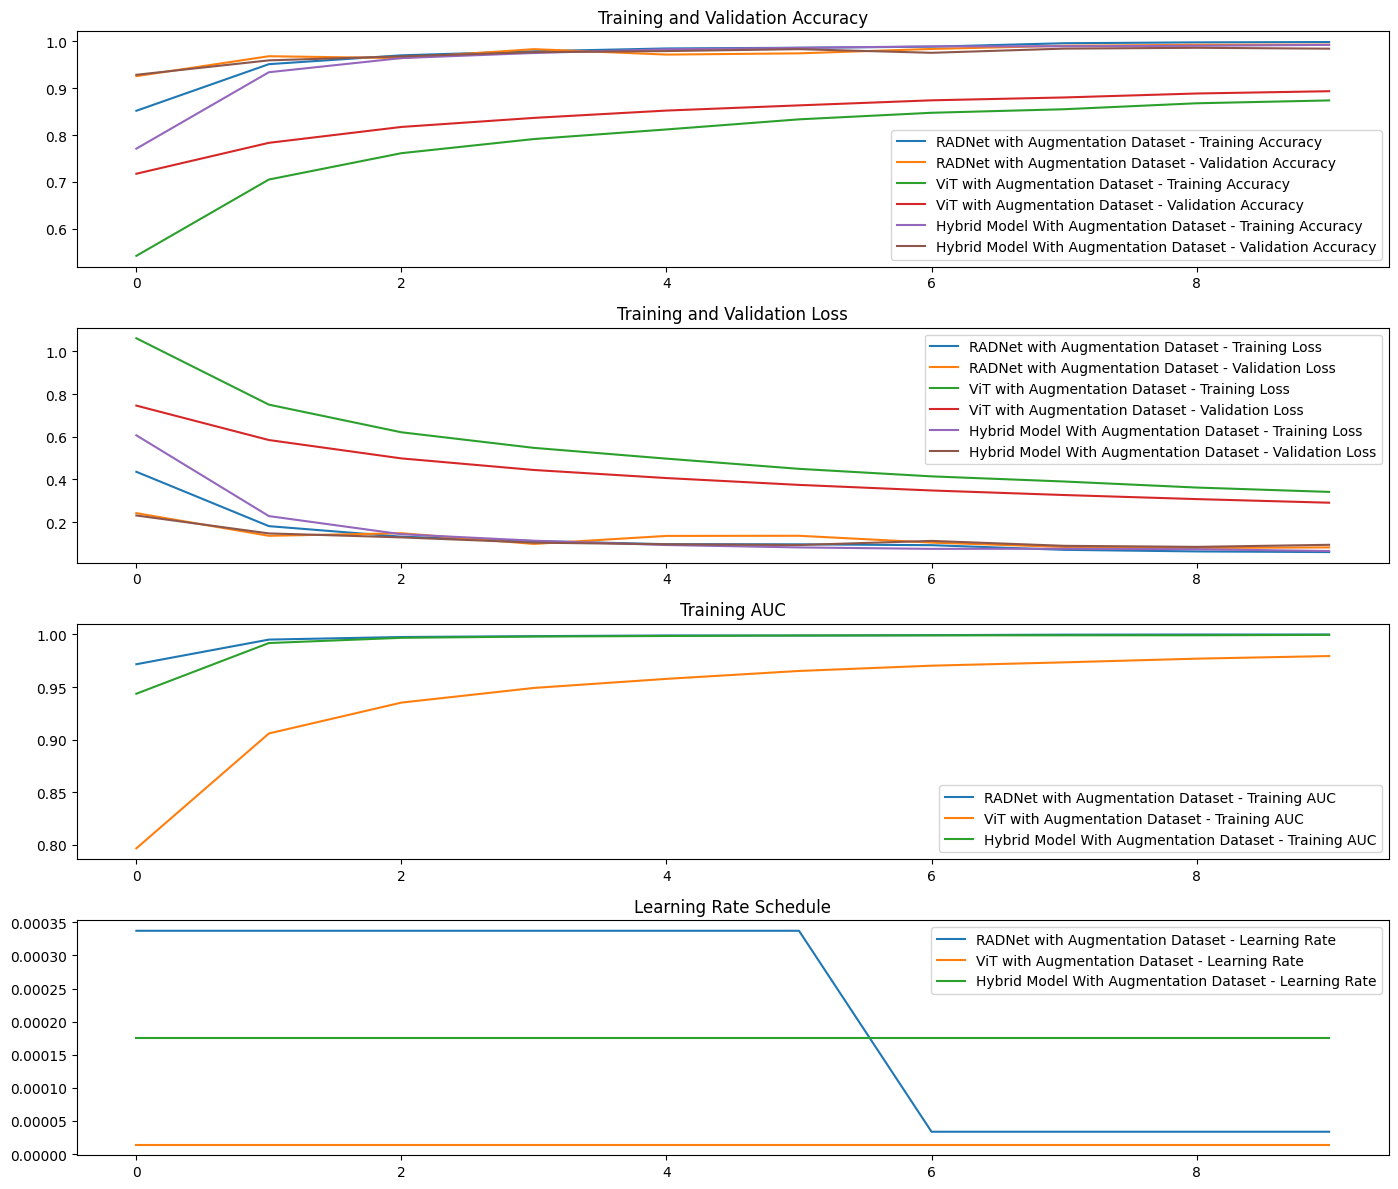

In [84]:
histories = [history_large_radnet, history_large_vit, history_hybrid_large]
titles = ["RADNet with Augmentation Dataset", "ViT with Augmentation Dataset", "Hybrid Model With Augmentation Dataset"]
plot_combined_history(histories, titles)

### Evaluation of all Models with Augmented Dataset

RADNet with Augmentation Dataset - Test Loss: 0.08157312124967575, Test Accuracy: 0.993000864982605, Test AUC: 0.9989409446716309
322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
RADNet with Augmentation Dataset - Precision: 0.99
RADNet with Augmentation Dataset - Recall: 0.99
RADNet with Augmentation Dataset - F1 Score: 0.99
RADNet with Augmentation Dataset - AUC: 1.00




Confusion Matrix:


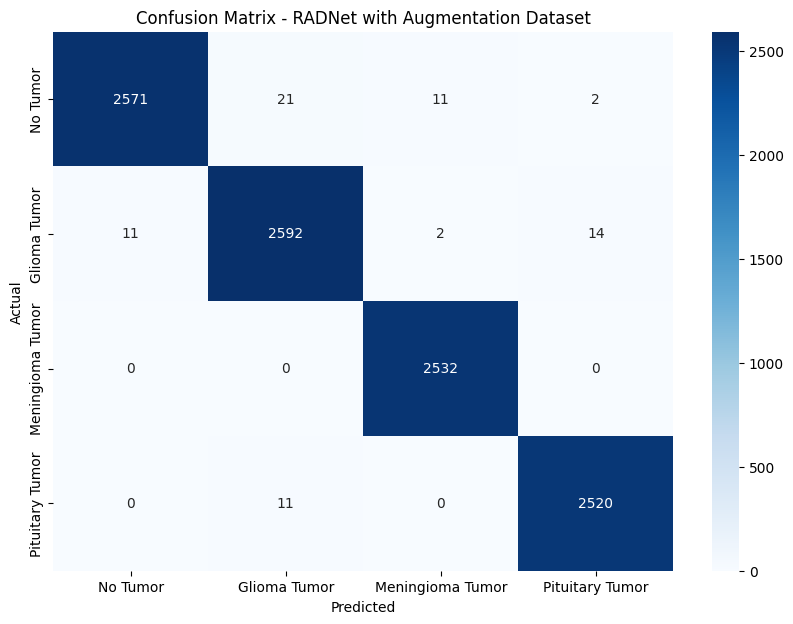





Classification Report:
                  precision    recall  f1-score   support

        No Tumor       1.00      0.99      0.99      2605
    Glioma Tumor       0.99      0.99      0.99      2619
Meningioma Tumor       0.99      1.00      1.00      2532
 Pituitary Tumor       0.99      1.00      0.99      2531

        accuracy                           0.99     10287
       macro avg       0.99      0.99      0.99     10287
    weighted avg       0.99      0.99      0.99     10287



ViT with Augmentation Dataset - Test Loss: 0.29108747839927673, Test Accuracy: 0.8935549855232239, Test AUC: 0.9849587678909302
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
ViT with Augmentation Dataset - Precision: 0.89
ViT with Augmentation Dataset - Recall: 0.89
ViT with Augmentation Dataset - F1 Score: 0.89
ViT with Augmentation Dataset - AUC: 0.98




Confusion Matrix:


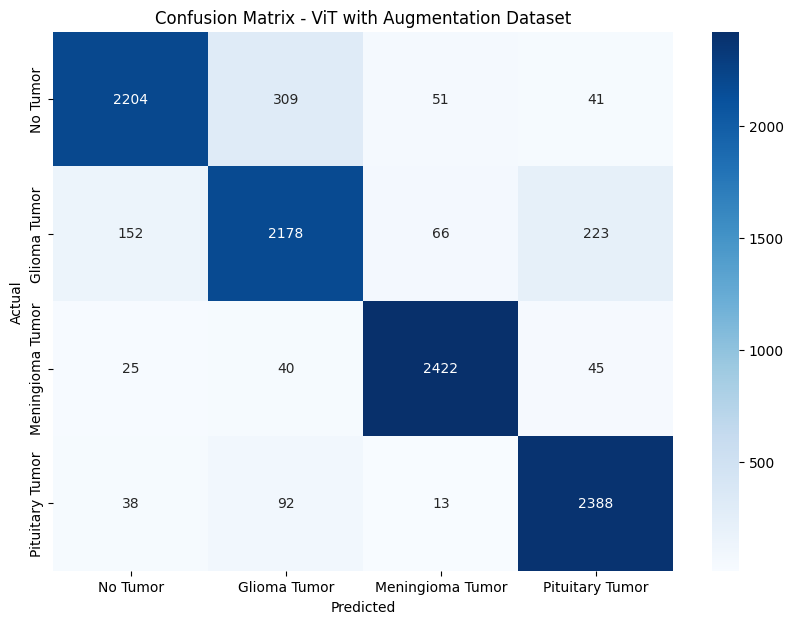





Classification Report:
                  precision    recall  f1-score   support

        No Tumor       0.91      0.85      0.88      2605
    Glioma Tumor       0.83      0.83      0.83      2619
Meningioma Tumor       0.95      0.96      0.95      2532
 Pituitary Tumor       0.89      0.94      0.91      2531

        accuracy                           0.89     10287
       macro avg       0.89      0.89      0.89     10287
    weighted avg       0.89      0.89      0.89     10287



Hybrid Model with Augmentation Dataset - Test Loss: 0.09381332248449326, Test Accuracy: 0.9844464063644409, Test AUC: 0.9983378052711487
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
Hybrid Model with Augmentation Dataset - Precision: 0.98
Hybrid Model with Augmentation Dataset - Recall: 0.98
Hybrid Model with Augmentation Dataset - F1 Score: 0.98
Hybrid Model with Augmentation Dataset - AUC: 1.00




Confusion Matrix:


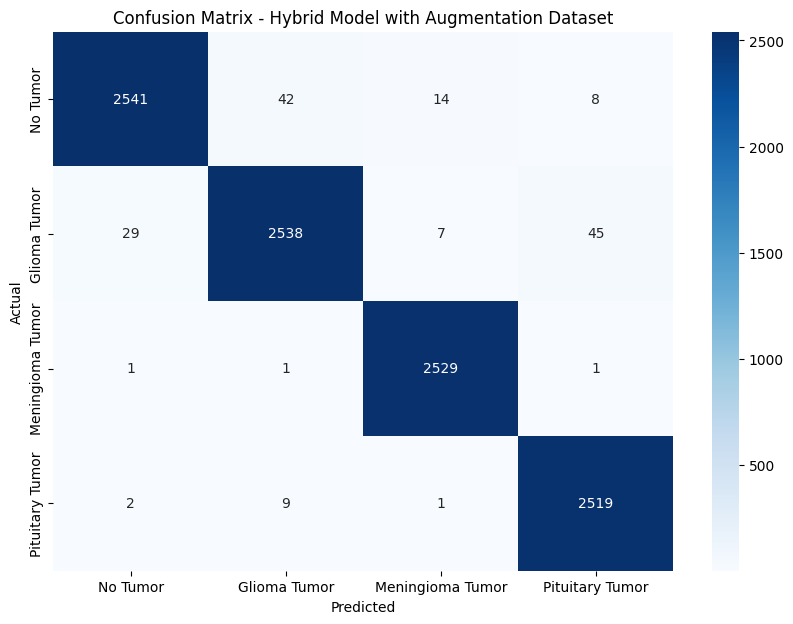





Classification Report:
                  precision    recall  f1-score   support

        No Tumor       0.99      0.98      0.98      2605
    Glioma Tumor       0.98      0.97      0.97      2619
Meningioma Tumor       0.99      1.00      1.00      2532
 Pituitary Tumor       0.98      1.00      0.99      2531

        accuracy                           0.98     10287
       macro avg       0.98      0.98      0.98     10287
    weighted avg       0.98      0.98      0.98     10287



In [85]:
# Evaluate model
evaluate_model(radnet_model_large, new_X_test, new_Y_test, "RADNet with Augmentation Dataset", category_names)
print()
print()
evaluate_model(vit_model_large, new_X_test, new_Y_test, "ViT with Augmentation Dataset", category_names)
print()
print()
evaluate_model(hybrid_model_large, new_X_test, new_Y_test, "Hybrid Model with Augmentation Dataset", category_names)


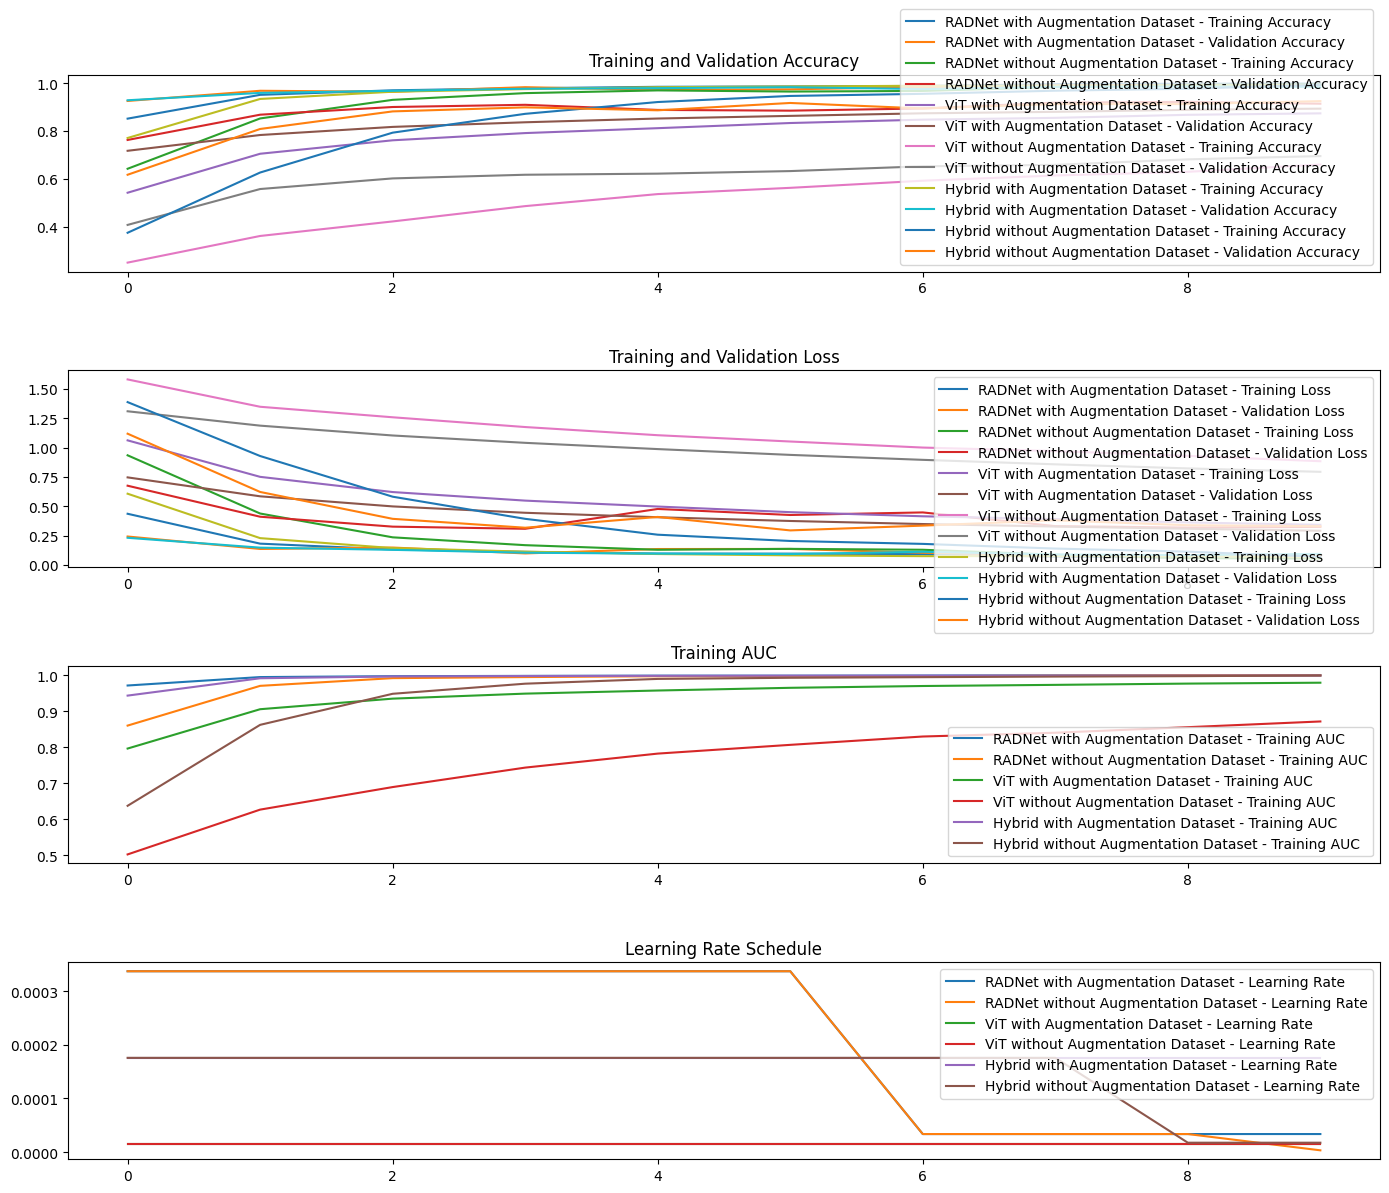

In [90]:
histories = [history_large_radnet, history_small_radnet, history_large_vit, history_small_vit, history_hybrid_large, history_hybrid_small]
titles = ["RADNet with Augmentation Dataset", "RADNet without Augmentation Dataset", "ViT with Augmentation Dataset", "ViT without Augmentation Dataset",  "Hybrid with Augmentation Dataset", "Hybrid without Augmentation Dataset"]
plot_combined_history(histories, titles)